In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string
import seaborn as sns

import scipy as sp
from scipy import sparse
import sklearn
import umap

## add your packages ##

import time
import pickle
import memory_profiler
from collections import Counter
import matplotlib.colors as mcolors

%load_ext memory_profiler

from pathlib import Path

In [2]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [3]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../datX")

In [4]:
plt.style.use("matplotlib_style.txt")

In [5]:
np.random.seed(42)

# Data

We are going to use the multimodal data from the paper Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). In particular, you will work with transcriptomics and electrophysiological data. From the transcriptomics gene counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out for the project.

## Import

### Meta data

In [6]:
# META DATA

meta = pd.read_csv("data/m1_patchseq_meta_data.csv", sep="\t")

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [
        c if c[-1] != "+" and c[-1] != "-" else c[:-1]
        for c in meta["Cre"].values
    ]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [
        np.unique(meta["Date"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse age"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse"].values[sliceids == s]).size == 1
        for s in sliceids
    ]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


### Transcriptomic data

In [7]:
# READ COUNTS

data_exons = pd.read_csv(
    "data/m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
exonCounts = data_exons.values.transpose()

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

print("Count matrix shape (exon):  ", exonCounts.shape)

Count matrix shape (exon):   (1329, 42466)


In [8]:
data_exons

20171204_sample_2  20171204_sample_4  20171204_sample_5  \
0610005C13Rik                  0                  0                  0   
0610006L08Rik                  0                  0                  0   
0610009B22Rik                  0                 68               1291   
0610009E02Rik                  0                  0                  0   
0610009L18Rik                  0                  0                  0   
...                          ...                ...                ...   
n-R5s96                        0                  0                  0   
n-R5s97                        0                  0                  0   
n-R5s98                        0                  0                  0   
n-TSaga9                       0                  0                  0   
n-TStga1                       0                  0                  0   

               20171204_sample_6  20171207_sample_1  20171207_sample_2  \
0610005C13Rik                  0                  0                  1   
0610006L08Rik                  0                  0                 13   
0610009B22Rik                  0                  0                  0   
0610009E02Rik                  0                 30                 80   
0610009L18Rik                  0                  0                 99   
...                          ...                ...                ...   
n-R5s96                        0                  0                  0   
n-R5s97                        0                  0                  0   
n-R5s98                        0                  0                  0   
n-TSaga9                       0                  0                  0   
n-TStga1                       0                  0                  0   

               20171207_sample_6  20171207_sample_7  20171219_sample_1  \
0610005C13Rik                  0                  0                  0   
0610006L08Rik                  0                  0                  0   
0610009B22Rik                227                  0                  7   
0610009E02Rik                205                  0                  0   
0610009L18Rik                  0                380                  0   
...                          ...                ...                ...   
n-R5s96                        0                  0                  0   
n-R5s97                        0                  0                  0   
n-R5s98                        0                  0                  0   
n-TSaga9                       0                  0                  0   
n-TStga1                       0                  0                  0   

               20171219_sample_2  ...  20191114_sample_9  20200106_sample_1  \
0610005C13Rik                  0  ...                  0                  0   
0610006L08Rik                  0  ...                  0                  0   
0610009B22Rik                 10  ...                  0                271   
0610009E02Rik                 14  ...                  0                  0   
0610009L18Rik                  0  ...                  0                  0   
...                          ...  ...                ...                ...   
n-R5s96                        0  ...                  0                  0   
n-R5s97                        0  ...                  0                  0   
n-R5s98                        0  ...                  0                  0   
n-TSaga9                       0  ...                  0                  0   
n-TStga1                       0  ...                  0                  0   

               20200106_sample_4  20200106_sample_5  20200106_sample_6  \
0610005C13Rik                  0                  0                  1   
0610006L08Rik                  0                  0                  0   
0610009B22Rik                  0                  0                  0   
0610009E02Rik                  0                  0                  0   
0610009L18Rik                

In [9]:
# GENE LENGTH

data = pd.read_csv("data/gene_lengths.txt")
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values
intronLengths = data["intron_bp"].values

### Cluster colors

In [10]:
cluster_colors = np.load("data/cluster_colors.npy")

In [11]:
cluster_colors.shape

(1329,)

In [12]:
rna_type = np.load("data/rna_type.npy", allow_pickle=True)

In [13]:
rna_type.shape

(1329,)

In [14]:
pickle_in = open("data/dict_rna_type_colors.pkl", "rb")
dict_rna_type_colors = pickle.load(pickle_in)

In [15]:
len(dict_rna_type_colors)

88

### Electrophysiological features

In [16]:
# EPHYS DATA

ephysData = pd.read_csv("data/m1_patchseq_ephys_features.csv")
ephysData = ephysData.sort_values(by="cell id")  # !!!!!!! ADDED !!!!!!!!
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [
        names2ephys[c] if c in names2ephys else ephysData[0] * np.nan
        for c in cells
    ]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [17]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]

features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData
ephysfeatures = X.copy()
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)
X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

features_exclude_set = set(features_exclude)  ## ADDED
ephysNames = np.array(
    [name for name in ephysNames if name not in features_exclude_set]
)  # ADDED

(1329, 29)
(1320, 17)


# Research questions to investigate

**1) Inspect the data computing different statistics.** Keep in mind that the data is read counts, not UMI, so it is not supposed to follow a Poisson distribution.

**2) Normalize and transform the data.** There are several ways of normalizing the data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization.

**3) Two-dimensional visualization.** Try different methods (t-SNE, UMAP) / parameters (exagg., perplex.) for visualizations. Compare them using quantitative metrics (e.g., distance correlation, kNN accuracy/recall in high-dim vs. two-dim). Think about also using the electrophysiological features for different visualizations.

**4) Clustering.** Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2) and S (set of important genes). Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation in between electrophysiological features and genes/PCs.** Find correlations and a way of visualizing them.
    

### Introduction

## 1) Inspect The Data ##

### Meta data

In [18]:
# number of mice
mouse_all = meta["Mouse"].values.astype("str")
n_mice = len(np.unique(mouse_all))
print(f"The dataset consists of {n_mice} different mice.")

The dataset consists of 266 different mice.


In [19]:
# Gender
mouse_genders = meta["Mouse gender"].values.astype("str")
genders, gender_counts = np.unique(mouse_genders, return_counts=True)
percentages_gender = {
    gender: (count / len(mouse_genders)) * 100
    for gender, count in zip(genders, gender_counts)
}

for gender, percentage in percentages_gender.items():
    print(f"Percentage of {gender} mice: {percentage:.2f}%")

Percentage of F mice: 51.47%
Percentage of M mice: 48.53%


In [20]:
# Genotype
mouse_genotypes = meta["Mouse genotype"].values.astype("str")
genotype_counts = Counter(mouse_genotypes)
genotype_percentages = {
    genotype: (count / len(mouse_genotypes)) * 100
    for genotype, count in genotype_counts.items()
}
print(genotype_percentages)

# Combine all genotypes with less than 5%
genotype_summary = {
    k: v
    for k, v in genotype_counts.items()
    if v >= 0.05 * len(mouse_genotypes)
}
other_genotypes_count = sum(
    v for k, v in genotype_counts.items() if v < 0.05 * len(mouse_genotypes)
)
genotype_summary["Other genotypes"] = other_genotypes_count

# Custom colormap
cmap = plt.get_cmap("Blues")
norm = mcolors.Normalize(vmin=0, vmax=len(genotype_summary))
colors = [cmap(norm(i)) for i in range(len(genotype_summary))]

{'Pvalb-Cre/wt; Ai9/wt': 29.044394281414597, 'Sst-IRES-Cre/wt; Ai9/wt': 28.74341610233258, 'Viaat-Cre/wt; Ai9/wt': 8.577878103837472, 'wt/wt': 9.029345372460497, 'Scnn1a-Tg3-Cre/wt; Ai9/wt': 0.07524454477050413, 'Vip-IRES-Cre/wt; Ai9/wt': 17.155756207674944, 'Vipr2-IRES2-Cre-D/wt; Ai9/wt': 3.235515425131678, 'Slc17a8-IRES2-Cre-D/wt; Ai9/wt': 2.784048156508653, 'Npy-Cre/wt; Ai9/wt': 0.6772009029345373, 'Vglut3-Cre/wt; Ai9/wt': 0.4514672686230248, 'Gnb4-IRES2-CreER2-D knock-in/wt; Ai9/wt': 0.2257336343115124}


In [21]:
# Age
mouse_ages = list(mice_ages.values())
mean_age = np.mean(mouse_ages)

In [22]:
# Normalized soma depth
filtered_thickness = thickness[~np.isnan(thickness) & ~np.isnan(depth)]
filtered_depth = depth[~np.isnan(thickness) & ~np.isnan(depth)]

# Normalize depth by thickness
normalized_depth = filtered_depth / filtered_thickness
mean_depth = np.mean(normalized_depth)

C:\Users\nekur\AppData\Local\Temp\ipykernel_20604\1631768841.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


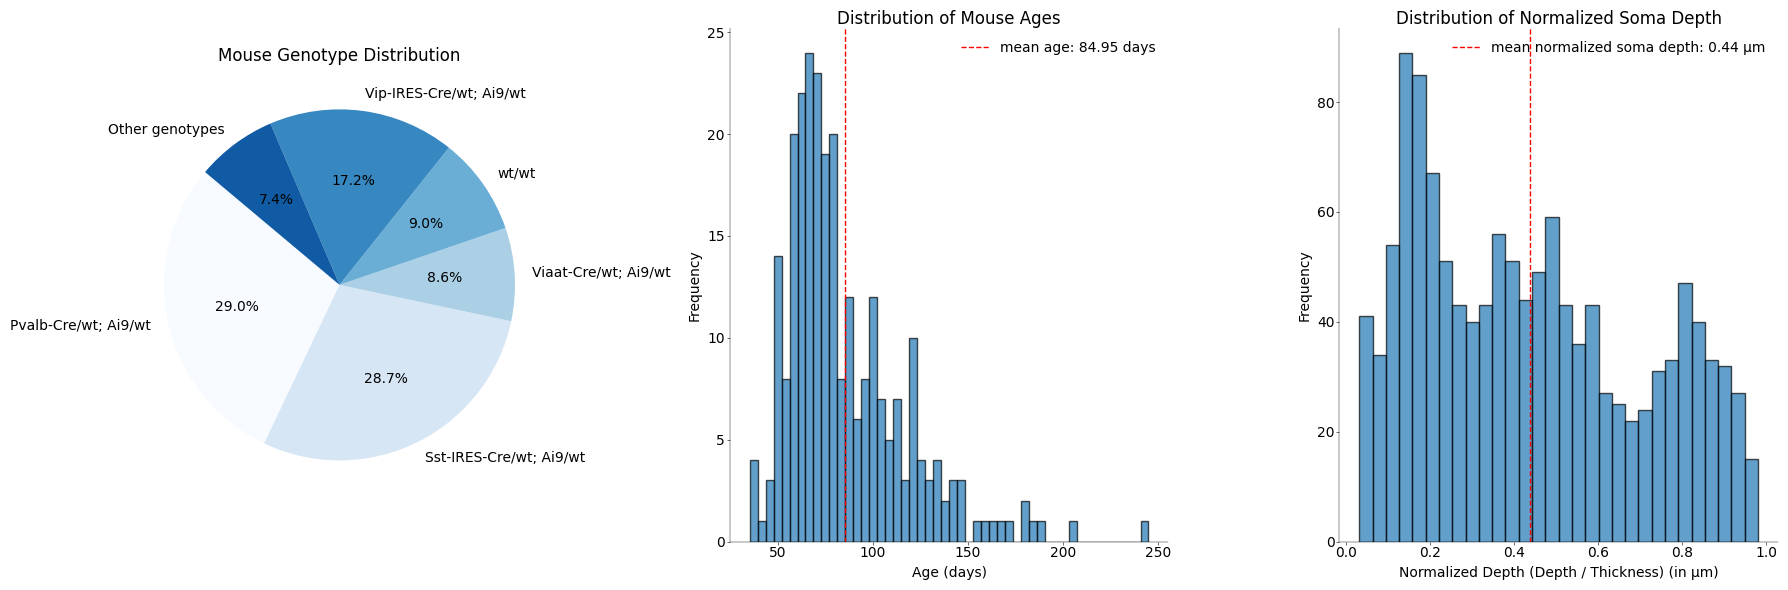

In [23]:
# Plot
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.pie(
    genotype_summary.values(),
    labels=genotype_summary.keys(),
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
)
plt.title("Mouse Genotype Distribution")

plt.subplot(1, 3, 2)
plt.hist(mouse_ages, bins=50, alpha=0.7, edgecolor="black")
plt.axvline(
    mean_age,
    color="r",
    linestyle="dashed",
    label=f"mean age: {mean_age:.2f} days",
)
plt.title("Distribution of Mouse Ages")
plt.xlabel("Age (days)")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(normalized_depth, bins=30, alpha=0.7, edgecolor="black")
plt.axvline(
    mean_depth,
    color="r",
    linestyle="dashed",
    label=f"mean normalized soma depth: {mean_depth:.2f} µm",
)
plt.xlabel("Normalized Depth (Depth / Thickness) (in µm)")
plt.ylabel("Frequency")
plt.title("Distribution of Normalized Soma Depth")
plt.legend()

plt.tight_layout()
plt.show()

The datasets consists of experiments that were being made on a mouse population of n=266 mice (48.53% / 51.47% male/female) with an average age of 84.95 days (see more detailed mouse age distribution above). The distribution of mouse genotypes can be obtained in th epie chart above ("other genotypes" summarizes all genotypes that have an occurance of less than 5%. Those are in particular Scnn1a-Tg3-Cre/wt; Ai9/wt  (0.08%), Vipr2-IRES2-Cre-D/wt; Ai9/wt (3.24%), Slc17a8-IRES2-Cre-D/wt; Ai9/wt (2.78%), Npy-Cre/wt; Ai9/wt (0.68%), Vglut3-Cre/wt; Ai9/wt (0.45%), Gnb4-IRES2-CreER2-D knock-in/wt; Ai9/wt (0.23%)).

### Transcriptomics data

In [24]:
# gene expression analysis

gene_means = np.mean(exonCounts, axis=0)
gene_means_sorted_ids = np.argsort(-gene_means)
gene_medians = np.median(exonCounts, axis=0)
gene_var = np.var(exonCounts, axis=0)

# genes that were not expressed at all
n_not_expressed = np.shape(np.where(np.sum(exonCounts, axis=0) == 0))[1]

# number of cells that express a certain gene
n_cells_per_genes = np.sum(exonCounts > 0, axis=0)
n_cells_per_genes_sorted_ids = np.argsort(-n_cells_per_genes)

C:\Users\nekur\AppData\Local\Temp\ipykernel_20604\1144123460.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


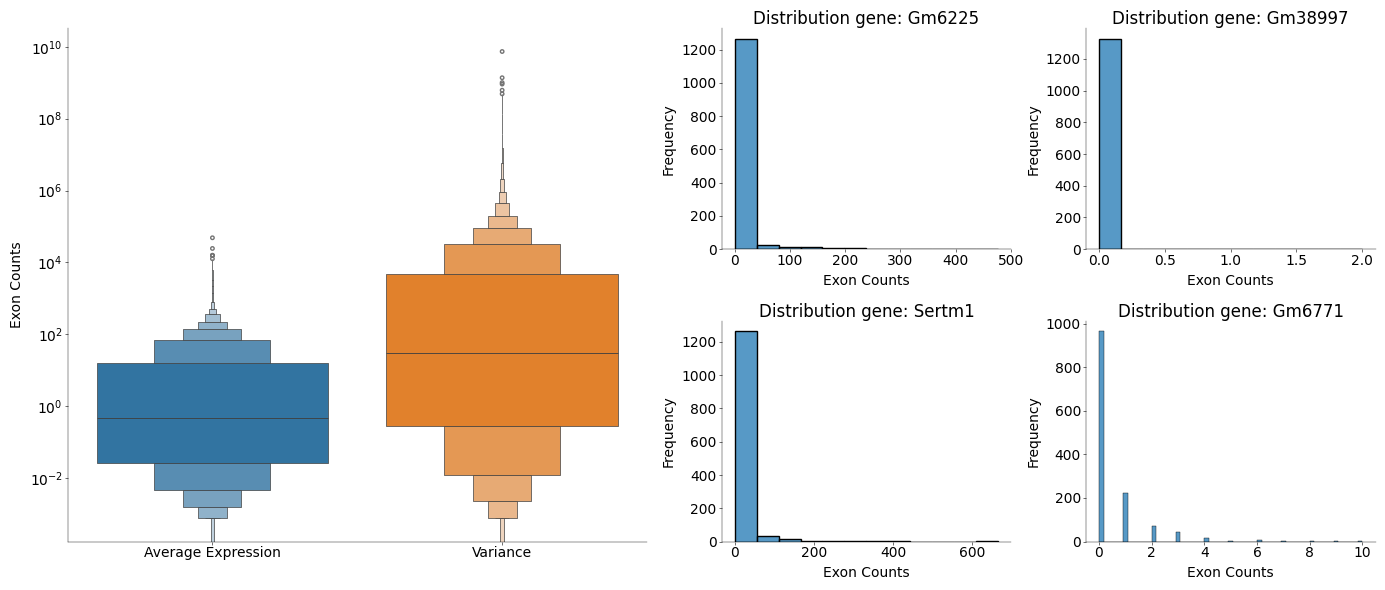

Avg exon counts of all genes: 37.74 (std: 344.96)
Avg number of cells that express a certain gene: 211.76 (std: 314.99)


The 5 most expressed genes on average:
1: CT010467.1: 	 48376.94 (std: 86179.43)
2: Gm26917: 	 24400.66 (std: 37173.28)
3: ERCC-00074: 	 15767.69 (std: 30343.80)
4: ERCC-00130: 	 15719.69 (std: 31804.46)
5: Snhg11: 	 15422.83 (std: 18551.54)
269 genes were not expressed at all


The 5 genes that were expressed by the most cells:
1: CT010467.1: 	 1327
2: mt-Rnr2: 	 1323
3: Lars2: 	 1322
4: Gm20388: 	 1321
5: Rn7s1: 	 1321


In [25]:
# Define the GridSpec layout
fig = plt.figure(figsize=(14, 6))
gs = plt.GridSpec(2, 3, width_ratios=[2, 1, 1], height_ratios=[1, 1])

ax_main = fig.add_subplot(gs[:, 0])
sns.boxenplot(data=[gene_means, gene_var], ax=ax_main)
ax_main.set_xticks([0, 1])
ax_main.set_xticklabels(["Average Expression", "Variance"])
ax_main.set_ylabel("Exon Counts")
ax_main.set_yscale("log")

np.random.seed(1)
random_genes = np.random.choice(data_exons.index, 4, replace=False)

axes = []
for i in range(2):
    for j in range(1, 3):
        ax = fig.add_subplot(gs[i, j])
        axes.append(ax)

for idx, gene in enumerate(random_genes):
    ax = axes[idx]
    sns.histplot(data_exons.loc[gene], kde=False, ax=ax)
    ax.set_title(f"Distribution gene: {gene}")
    ax.set_xlabel("Exon Counts")
    ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

# print some results
print(
    f"Avg exon counts of all genes: {np.mean(gene_means):.2f} (std: {np.std(gene_means):.2f})"
)
print(
    f"Avg number of cells that express a certain gene: {np.mean(n_cells_per_genes):.2f} (std: {np.std(n_cells_per_genes):.2f})"
)
print("\n")
print(f"The 5 most expressed genes on average:")
for i in range(5):
    print(
        f"{i+1}: {data_exons.index[gene_means_sorted_ids[i]]}: \t {gene_means[gene_means_sorted_ids[i]]:.2f} (std: {np.std(exonCounts[:, gene_means_sorted_ids[i]]):.2f})"
    )
print(f"{n_not_expressed} genes were not expressed at all")
print("\n")
print(f"The 5 genes that were expressed by the most cells:")
for i in range(5):
    print(
        f"{i+1}: {data_exons.index[n_cells_per_genes_sorted_ids[i]]}: \t {n_cells_per_genes[n_cells_per_genes_sorted_ids[i]]}"
    )

In [26]:
# cell specific expression

# how many different genes does a cell express on average
n_genes_per_cell = np.sum(data_exons.values > 0, axis=0)
n_genes_per_cell_sorted_ids = np.argsort(-n_genes_per_cell)

# get sequencing depth for each cell
seq_depth = np.sum(data_exons.values, axis=0)

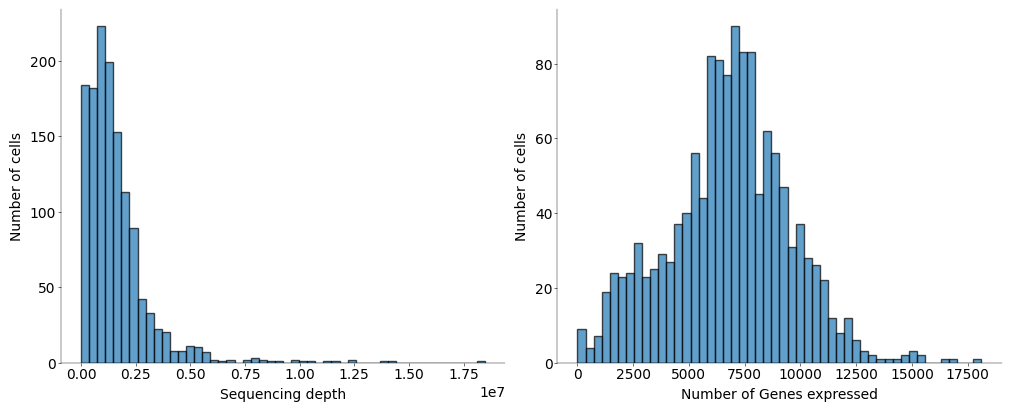

Average number of genes expressed over all cells: 6766.39 (std: 2742.47)
The 5 cells that expressed the most number of different genes:
0: 0610010F05Rik: 	 18118
1: 1110017D15Rik: 	 16845
2: 0610009L18Rik: 	 16310
3: 0610012G03Rik: 	 15527
4: 1110002J07Rik: 	 15372


The 5 cells that expressed the least number of different genes:
1: 1600014C23Rik: 	 5
2: 1700120G07Rik: 	 24
3: 1700120C18Rik: 	 26
4: 1700010B08Rik: 	 45
5: 1700080N15Rik: 	 69


In [53]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(seq_depth, bins=50, alpha=0.7, edgecolor="black")
ax[0].set_xlabel("Sequencing depth")
ax[0].set_ylabel("Number of cells")
ax[1].hist(n_genes_per_cell, bins=50, alpha=0.7, edgecolor="black")
ax[1].set_xlabel("Number of Genes expressed")
ax[1].set_ylabel("Number of cells")
plt.show()

# print results
print(
    f"Average number of genes expressed over all cells: {np.mean(n_genes_per_cell):.2f} (std: {np.std(n_genes_per_cell):.2f})"
)
print(f"The 5 cells that expressed the most number of different genes:")
for i in range(5):
    print(
        f"{i}: {data_exons.index[n_genes_per_cell_sorted_ids[i]]}: \t {n_genes_per_cell[n_genes_per_cell_sorted_ids[i]]}"
    )
print("\n")
print(f"The 5 cells that expressed the least number of different genes:")
for i in range(1, 6):
    print(
        f"{i}: {data_exons.index[n_genes_per_cell_sorted_ids[-i]]}: \t {n_genes_per_cell[n_genes_per_cell_sorted_ids[-i]]}"
    )

Due to the differences in sequencing depth and gene lenght the statistics of the exon count data shows a large variance indicating a need of normalization that counteracts these technical biases and makes the data more comparable within and across samples.

## 2) Normalize and Transform the Data ##

Normalizations and transformations help to standardize the data, making it more comparable across samples and more suitable for further analyses. We implemented the following normalizations:

##### CPM (Counts per Million):

\begin{align*}
CPM_{ij} = \frac{c_{ij}}{s_i} * 10^6
\end{align*}
with $c_{ij}$ being the number of reads of gene $j$ in sample $i$ and $s_i$ the total number reads mapped in sample $i$. CPM normalizes the exon count by the sequencing depth but is independent of the gene length. Its output is given in counts per million reads.

##### CPMedian:

\begin{align*}
CPM_{ij} = \frac{c_{ij}}{s_i} * median(s)
\end{align*}
similar to CPM but scales the reads with the median sequencing depth across all samples minimizing the impact of outliers.  

##### RPKM (Reads per kilo base of transcript per million mapped reads):

\begin{align*}
RPKM_{ij} = 10^9 * \frac{c_{ij}}{s_i * l_j}
\end{align*}
with $l_j$ being the gene length of gene $j$ ensuring a normalization with respect to the gene lenght and sequencing depth.

In [28]:
def cpm(counts):
    seq_depth = np.sum(counts, axis=1)
    normed = (counts / seq_depth[:, np.newaxis]) * 1e6
    return normed


def cpmedian(counts):
    seq_depth = np.sum(counts, axis=1)
    normed = counts / seq_depth[:, np.newaxis] * np.median(seq_depth)
    return normed


def rpkm(
    counts, lengths
):  ## Taken from https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch01.html
    """Calculate reads per kilobase transcript per million reads.

    RPKM = (10^9 * C) / (N * L)

    Where:
    C = Number of reads mapped to a gene
    N = Total mapped reads in the experiment
    L = Exon length in base pairs for a gene

    Parameters
    ----------
    counts: array, shape (N_genes, N_samples)
        RNAseq (or similar) count data where columns are individual samples
        and rows are genes.
    lengths: array, shape (N_genes,)
        Gene lengths in base pairs in the same order
        as the rows in counts.

    Returns
    -------
    normed : array, shape (N_genes, N_samples)
        The RPKM normalized counts matrix.
    """
    N = np.sum(counts, axis=0)  # sum each column to get total reads per sample
    L = lengths
    C = counts

    normed = 1e9 * C / (N[np.newaxis, :] * L[:, np.newaxis])

    return normed.T


# exonCounts = sklearn.preprocessing.normalize(exonCounts)
cpm = cpm(exonCounts)
cpmedian = cpmedian(exonCounts)
rpkm = rpkm(exonCounts.T, exonLengths)

The transformation being used in this project were applied to make the data more suitable for furher analysis by modyfying the data distributions. We used the following transformation elementwise on the count data:

##### Square Root:

\begin{align*}
x \mapsto \sqrt{x}
\end{align*}
This transformation reduces the range of the data and can therefore lead to a stabilization of the variance.

##### Logarithm:

\begin{align*}
x \mapsto log_2(x+1) 
\end{align*}
Also reduces the range of the data and reduces the impact of large values. We add $+1$ inside the logarithm to avoid the undefined computation of $log(0)$.

In [29]:
## Transforms
def sqrt_transform(counts):
    return np.sqrt(counts)


def log_transform(counts):
    return np.log2(counts + 1)

## 3) Two-Dimensional visualization ##

To plot the high dimensional exon read data, we used the dimensionality reduction techniques t_SNE and UMAP. t-SNE (t-Distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique that maps high-dimensional data to lower dimensions and tries to preserves local structure. the ideaa of UMAP (Uniform Manifold Approximation and Projection). The idea is to embed the main structure of the high dimensional data into a lower dimensional space by constructing a high-dimensional graph representation of the data and then optimizing a low-dimensional graph to be as structurally similar as possible. These dimensionality reductions help in visualization of the data.

To measure the quality of the dimensionality reduction and optimize their hyperparameter, we used multiple metrics. First, let $X=\{x_1,...,x_n\}$ be the original, high dimensional data and $\hat{X}=\{\hat{x}_1,...,\hat{x}_n\}$ be its dimensionality reduction. The pairwise distance matrix is given by the euclidian distance between all datapoints:
\begin{align*}
D_{ij} = ||x_i - x_j||_2 (\text{high dimension}) \quad \hat{D}_{ij} = ||\hat{x}_i - \hat{x}_j||_2 \text{(low dimension)}.
\end{align*}

##### Distance Correlation
To determine the correlation between the distances in the high dimensional and the low dimensional data we use the metric
\begin{align*}
corr(D, \hat{D}) = \frac{cov(D, \hat{D})}{\sqrt{cov(D,D) cov(\hat{D}, \hat{D})}}
\end{align*}
with the covariance of two matrices $cov(X, Y)$ being computed by firstly double centering both matrices by applying the elemtwise transformation
\begin{align*}
\tilde{X}_{ij} = X_{ij} - \bar{X}_{\cdot j} - \bar{X}_{i \cdot} + \bar{X}
\end{align*}
with $\bar{X}_{\cdot j}$ being the mean of the column $j$ of $X$, $\bar{X}_{i \cdot}$ the mean of the row $i$, and $\bar{X}$ being the overall mean of all elements in $X$ (equivalently for $Y$) and then computing
\begin{align*}
cov(\mathbf{X}, \mathbf{Y}) = \sqrt{\frac{1}{n^2} \sum_{i=1}^{n} \sum_{j=1}^{n} \tilde{X}_{ij} \tilde{Y}_{ij}}.
\end{align*}
The value of the correlation ranges between −1 and +1. +1 identifying a perfect  (increasing) linear relationship, −1 in the case of a perfect inverse (decreasing) linear relationship, and 0 no correlation.

##### Rank Correlation
The rank correlation is defined by taking the two distance matrices and ranking each element of the individual matrices. The highest value gets rank 1, the second highest gets rank 2,.... For ties, assign the average of the possible ranks. After obtaining these rank matrices, we compute the Spearman Rank correlation between the two matrices.

##### k-nearest neigbors
For KNN for each datapoint $x_i$ we took the k=15 nearest neighbors (the 15 datapoints with the smallest euclidian distance to $x_i$), yielding the dataset of the nearest neighbors $N_{x_i}$. The same was done for the correspinding dimensionality redcution $\hat{x}_i$ yielding the set $N_{\hat{x}_i}$. The overlap between the two sets was defined as the number of datapoints for which the high dimensional data point $y \in N_{x_i}$ and its corresponding dimensionality reduction $\hat{y} \in N_{\hat{x}_i}$. We receive the accuracy of that datapoint $accuracy_i=\frac{overlap_i}{k}$. The overal KNN score was then defined as the average of all accuracy scores. 

##### Density Variance
The density variance is a simple form of grid cell density variance comparison. In this measurement we divide the 2D-clustering $\hat{X}$ into the same number of distinct cells and compare the number of datapoints in each cell. We create the cells by taking the maximal value over all datapoints of each direction and then creating a grid of 20 borders in each dimension, resulting in a total number of 400 cells with each a number $c_i$ that holds the number of datapoints within this cell. By taking the variance over all $c_i$, we have a measure of the variance of the density of cells. Clustering with a very low density variance fail to create meaningful clusters since all datapoints are evenly distributed.

In [30]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

c:\Users\nekur\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\nekur\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Condition            dist_corr  rank_corr  knn acc    density var
-----------------------------------------------------------------
Raw + None           0.81       0.75       0.41       14.58     
Raw + Log            0.70       0.47       0.29       27.44     
Raw + Sqrt           0.83       0.69       0.33       13.38     
CPM + None           0.86       0.77       0.42       9.88      
CPM + Log            0.71       0.50       0.32       16.48     
CPM + Sqrt           0.74       0.51       0.36       4.94      
CPMedian + None      0.86       0.78       0.42       10.72     
CPMedian + Log       0.71       0.50       0.31       15.04     
CPMedian + Sqrt      0.74       0.51       0.36       4.88      
RPKM + None          0.85       0.82       0.42       4.69      
RPKM + Log           0.69       0.47       0.32       23.57     
RPKM + Sqrt          0.85       0.70       0.34       11.34     


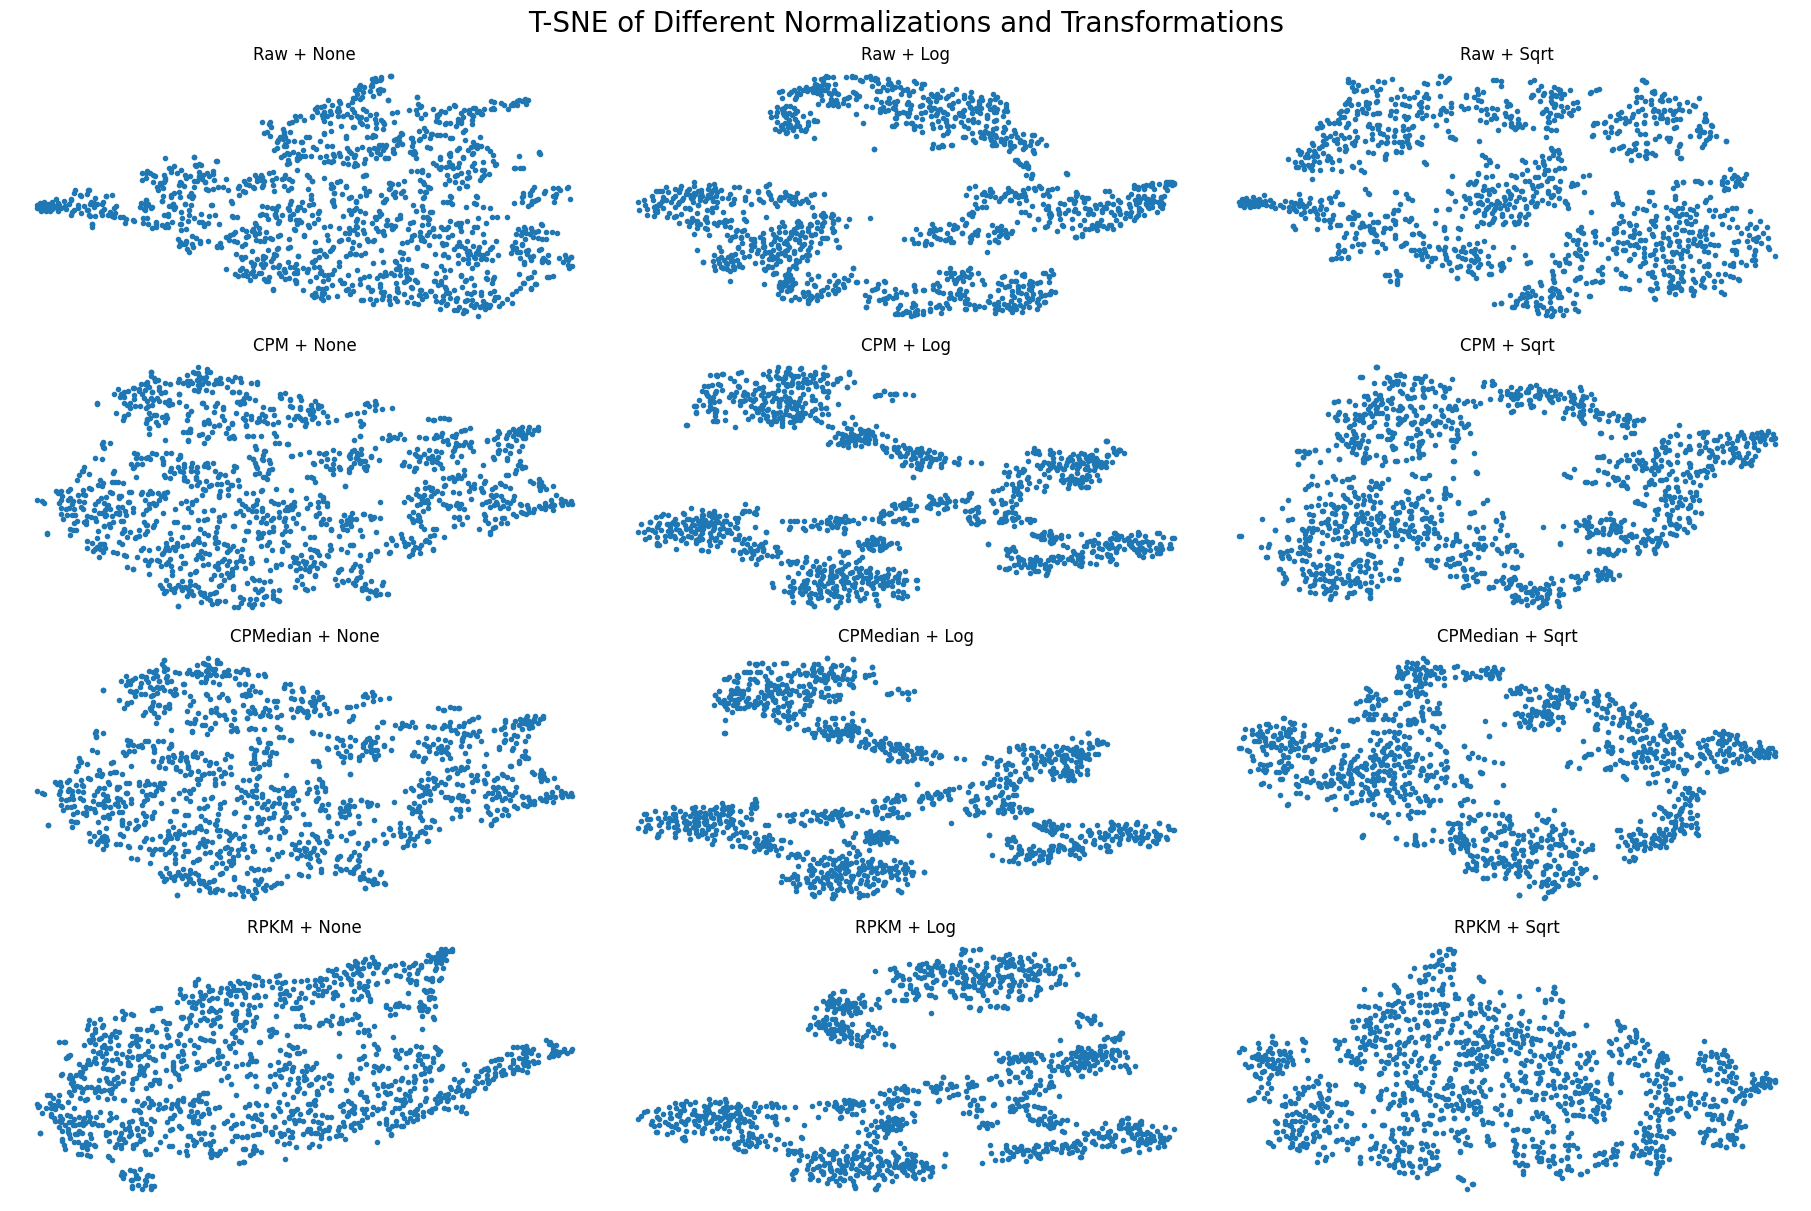

In [31]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import rankdata, spearmanr
from sklearn.metrics import silhouette_score


def distance_covariance(X, Y):
    n = X.shape[0]
    X -= X.mean(axis=0) + X.mean(axis=1)[:, np.newaxis] - X.mean()
    Y -= Y.mean(axis=0) + Y.mean(axis=1)[:, np.newaxis] - Y.mean()
    dcov = np.sqrt((X * Y).sum() / (n * n))
    return dcov


def distance_correlation(X, Y):
    dcov_XY = distance_covariance(X, Y)
    dcov_XX = distance_covariance(X, X)
    dcov_YY = distance_covariance(Y, Y)
    dcor = dcov_XY / np.sqrt(dcov_XX * dcov_YY)
    return dcor


normalizations = {
    "Raw": exonCounts,
    "CPM": cpm,
    "CPMedian": cpmedian,
    "RPKM": rpkm,
}

transformations = {
    "None": lambda x: x,
    "Log": log_transform,
    "Sqrt": sqrt_transform,
}

fig, axes = plt.subplots(
    len(normalizations), len(transformations), figsize=(18, 12)
)
fig.suptitle(
    "T-SNE of Different Normalizations and Transformations", fontsize=20
)

measures = np.zeros((len(normalizations), len(transformations), 4))

for i, (norm_name, norm_data) in enumerate(normalizations.items()):
    for j, (trans_name, trans_func) in enumerate(transformations.items()):
        data = norm_data[:, gene_var > np.sort(gene_var)[-501]]
        data_transformed = trans_func(data)
        pca_result = PCA(n_components=50).fit_transform(data_transformed)
        tsne = TSNE(n_components=2, perplexity=30)
        tsne_results = tsne.fit_transform(pca_result)

        ax = axes[i, j]
        ax.scatter(tsne_results[:, 0], tsne_results[:, 1])
        ax.set_title(f"{norm_name} + {trans_name}", fontsize=12)
        ax.axis("off")

        # calculate pairwise (cell) distances in 2d and high dimensional space
        dist_hd = squareform(pdist(data_transformed))
        dist_ld = squareform(pdist(tsne_results))

        # calculate distance correlations
        dcor = distance_correlation(dist_hd, dist_ld)
        measures[i, j, 0] = dcor

        # calculate distance ranks
        ranks_hd = rankdata(dist_hd)
        ranks_ld = rankdata(dist_ld)
        # calculate correlation of ranks
        spearman_corr, _ = spearmanr(ranks_hd, ranks_ld)
        measures[i, j, 1] = spearman_corr

        # calculate the knn for each cell in high and low dimensional space
        k = 15
        knn_hd = np.array([np.argsort(x)[1 : k + 1] for x in dist_hd])
        knn_ld = np.array([np.argsort(x)[1 : k + 1] for x in dist_ld])
        # calculate the number of overlapping neighbors
        accuracy = np.sum(
            [len(set(x) & set(y)) for x, y in zip(knn_hd, knn_ld)]
        ) / (knn_hd.shape[0] * k)
        measures[i, j, 2] = accuracy

        # calculate point density variance
        mins = np.min(tsne_results, axis=0)
        maxs = np.max(tsne_results, axis=1)
        # kde = KernelDensity(kernel="gaussian", bandwidth=10).fit(tsne_results)
        x_grid = np.linspace(mins[0] - 1, maxs[0] + 1, 20)
        y_grid = np.linspace(mins[1] - 1, maxs[1] + 1, 20)
        densities = np.zeros(len(x_grid) * len(y_grid))
        pos = 0
        for x, _ in enumerate(x_grid[:-1]):
            for y, _ in enumerate(y_grid[:-1]):
                densities[pos] = np.sum(
                    (
                        (tsne_results[:, 0] >= x_grid[x])
                        & (tsne_results[:, 0] < x_grid[x + 1])
                        & (tsne_results[:, 1] >= y_grid[y])
                        & (tsne_results[:, 1] < y_grid[y + 1])
                    )
                )
                pos += 1
        measures[i, j, 3] = np.var(densities)


# print measures as table
print(
    f"{'Condition':<20} {'dist_corr':<10} {'rank_corr':<10} {'knn acc':<10} {'density var':<10}"
)
print("-" * 65)
for i, (norm_name, norm_data) in enumerate(normalizations.items()):
    for j, (trans_name, trans_func) in enumerate(transformations.items()):
        condition = f"{norm_name} + {trans_name}"
        print(
            f"{condition:<20} {measures[i, j, 0]:<10.2f} {measures[i, j, 1]:<10.2f} {measures[i, j, 2]:<10.2f} {measures[i, j, 3]:<10.2f}"
        )

This plot shows the 2D embedding of t-SNE. 

The different transformations result in significant variations both in the metrics and visually in the embedding. Metrics show the best values for no transformation and the worst values for the logarithmic transformation. However, this does not hold visually for the 2D-embedding of t-SNE. In this case, the logarithmic transformation yields the best results, with the clusters being most distinctly separated. Therefore, we will use the logarithmic transformation in further analysis.

The different normalization methods only cause minor variations in both the metrics and the visual embedding. Thus, we will use the normalization method with the best metric values, which is CPM.

In [32]:
import umap.umap_ as umap

Condition            dist_corr  rank_corr  knn acc    density var
-----------------------------------------------------------------
Raw + None           0.81       0.74       0.35       1.78      
Raw + Log            0.65       0.44       0.25       31.91     
Raw + Sqrt           0.72       0.50       0.28       6.25      
CPM + None           0.87       0.77       0.38       6.56      
CPM + Log            0.68       0.46       0.29       66.62     
CPM + Sqrt           0.75       0.51       0.34       9.77      
CPMedian + None      0.87       0.77       0.38       6.32      
CPMedian + Log       0.67       0.47       0.29       68.26     
CPMedian + Sqrt      0.74       0.49       0.35       8.28      
RPKM + None          0.87       0.84       0.39       6.48      
RPKM + Log           0.66       0.46       0.31       60.11     
RPKM + Sqrt          0.85       0.69       0.32       3.34      


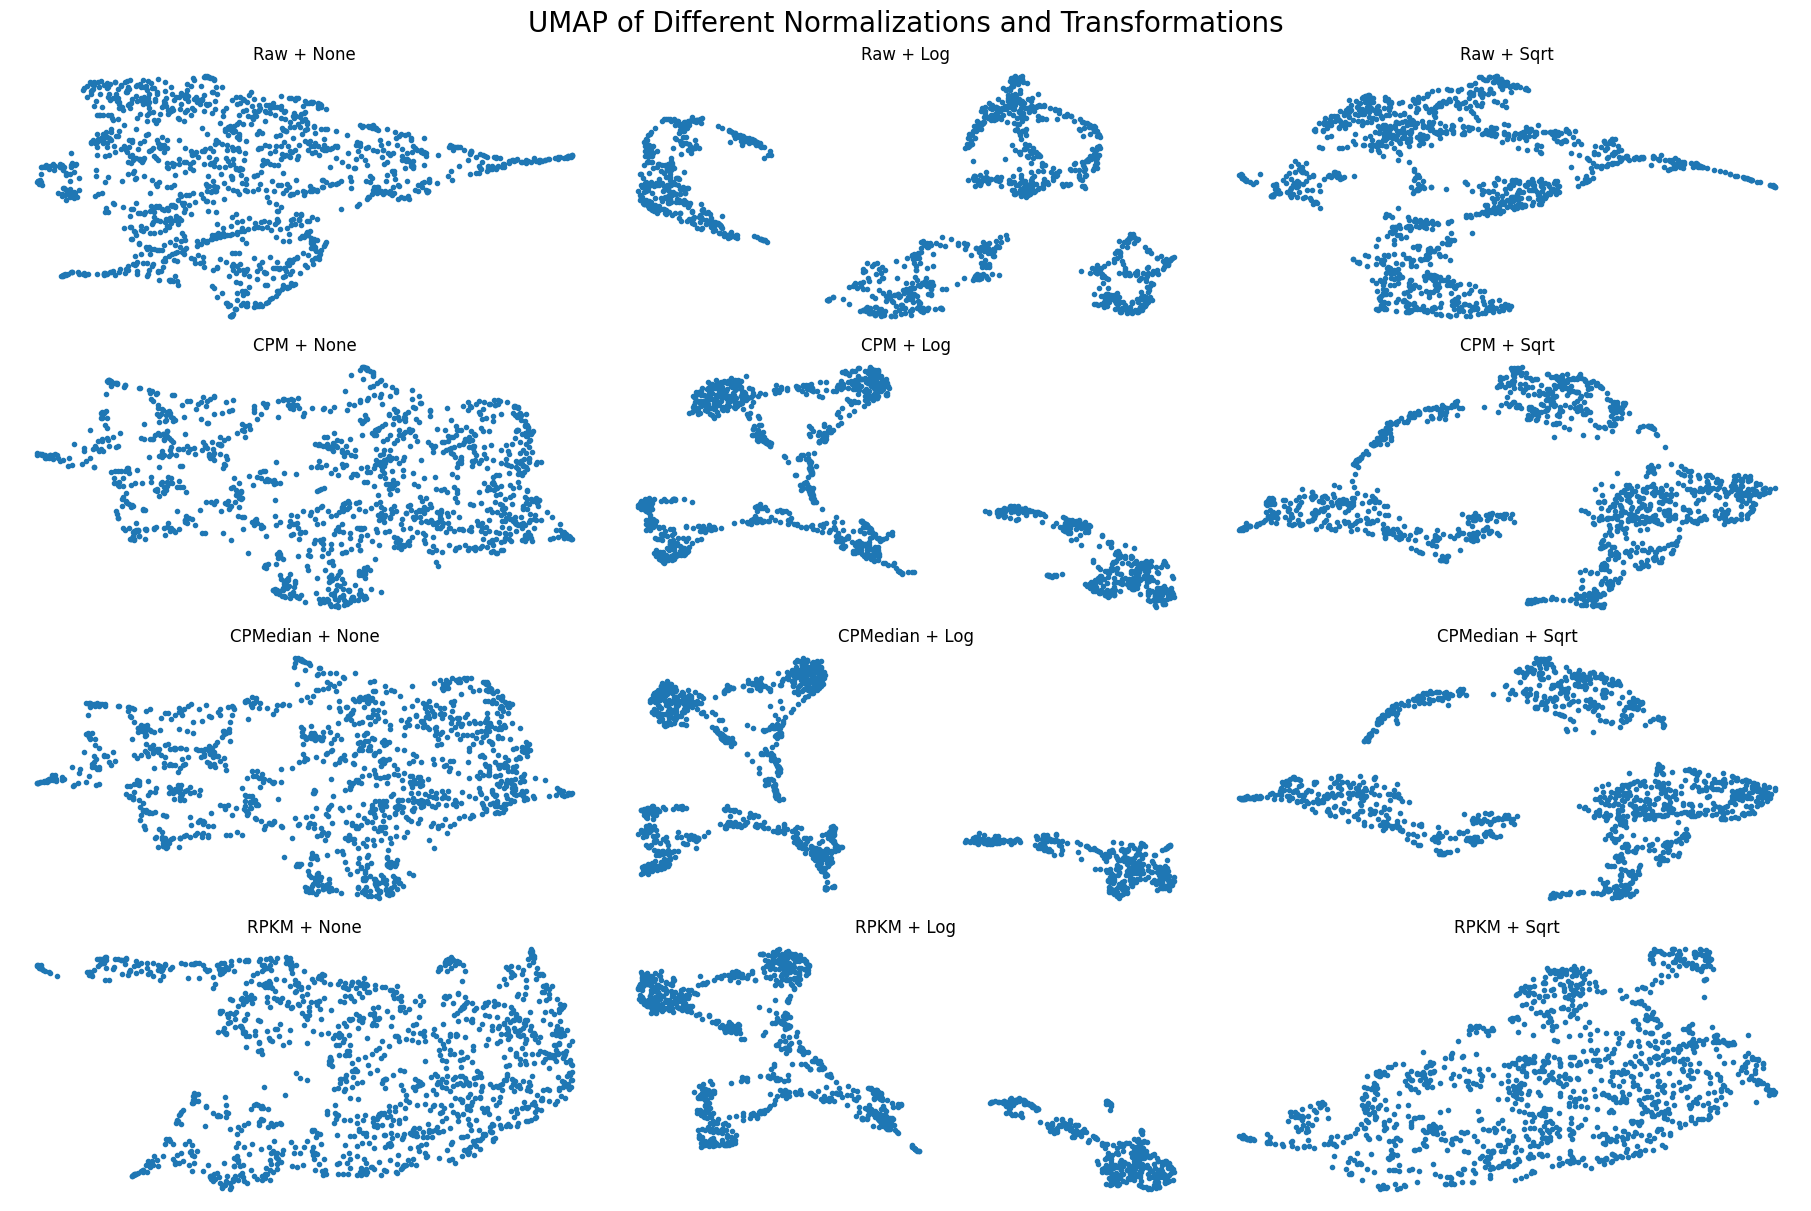

In [33]:
normalizations = {
    "Raw": exonCounts,
    "CPM": cpm,
    "CPMedian": cpmedian,
    "RPKM": rpkm,
}

transformations = {
    "None": lambda x: x,
    "Log": log_transform,
    "Sqrt": sqrt_transform,
}

fig, axes = plt.subplots(
    len(normalizations), len(transformations), figsize=(18, 12)
)
fig.suptitle(
    "UMAP of Different Normalizations and Transformations", fontsize=20
)

measures = np.zeros((len(normalizations), len(transformations), 4))

for i, (norm_name, norm_data) in enumerate(normalizations.items()):
    for j, (trans_name, trans_func) in enumerate(transformations.items()):
        data = norm_data[:, gene_var > np.sort(gene_var)[-501]]
        data_transformed = trans_func(data)
        pca_result = sklearn.decomposition.PCA(n_components=50).fit_transform(
            data_transformed
        )
        umap_model = umap.UMAP(random_state=7, n_jobs=1)
        umap_results = umap_model.fit_transform(pca_result)

        ax = axes[i, j]
        ax.scatter(umap_results[:, 0], umap_results[:, 1])
        ax.set_title(f"{norm_name} + {trans_name}", fontsize=12)
        ax.axis("off")

        # calculate pairwise (cell) distances in 2d and high dimensional space
        dist_hd = squareform(pdist(data_transformed))
        dist_ld = squareform(pdist(umap_results))

        # calculate distance correlations
        dcor = distance_correlation(dist_hd, dist_ld)
        measures[i, j, 0] = dcor

        # calculate distance ranks
        ranks_hd = rankdata(dist_hd)
        ranks_ld = rankdata(dist_ld)
        # calculate correlation of ranks
        spearman_corr, _ = spearmanr(ranks_hd, ranks_ld)
        measures[i, j, 1] = spearman_corr

        # calculate the knn for each cell in high and low dimensional space
        k = 15
        knn_hd = np.array([np.argsort(x)[1 : k + 1] for x in dist_hd])
        knn_ld = np.array([np.argsort(x)[1 : k + 1] for x in dist_ld])
        # calculate the number of overlapping neighbors
        accuracy = np.sum(
            [len(set(x) & set(y)) for x, y in zip(knn_hd, knn_ld)]
        ) / (knn_hd.shape[0] * k)
        measures[i, j, 2] = accuracy

        # calculate point density variance
        mins = np.min(umap_results, axis=0)
        maxs = np.max(umap_results, axis=1)
        # kde = KernelDensity(kernel="gaussian", bandwidth=10).fit(tsne_results)
        x_grid = np.linspace(mins[0] - 1, maxs[0] + 1, 20)
        y_grid = np.linspace(mins[1] - 1, maxs[1] + 1, 20)
        densities = np.zeros(len(x_grid) * len(y_grid))
        pos = 0
        for x, _ in enumerate(x_grid[:-1]):
            for y, _ in enumerate(y_grid[:-1]):
                densities[pos] = np.sum(
                    (
                        (umap_results[:, 0] >= x_grid[x])
                        & (umap_results[:, 0] < x_grid[x + 1])
                        & (umap_results[:, 1] >= y_grid[y])
                        & (umap_results[:, 1] < y_grid[y + 1])
                    )
                )
                pos += 1
        measures[i, j, 3] = np.var(densities)


# print measures as table
print(
    f"{'Condition':<20} {'dist_corr':<10} {'rank_corr':<10} {'knn acc':<10} {'density var':<10}"
)
print("-" * 65)
for i, (norm_name, norm_data) in enumerate(normalizations.items()):
    for j, (trans_name, trans_func) in enumerate(transformations.items()):
        condition = f"{norm_name} + {trans_name}"
        print(
            f"{condition:<20} {measures[i, j, 0]:<10.2f} {measures[i, j, 1]:<10.2f} {measures[i, j, 2]:<10.2f} {measures[i, j, 3]:<10.2f}"
        )


plt.show()

The UMAP embedding shows very similar results to the t-SNE embedding. Only the density var is smaller for the log transformation as the different clusters are very dense. Therefore we will be using t-SNE for future visualizations. 

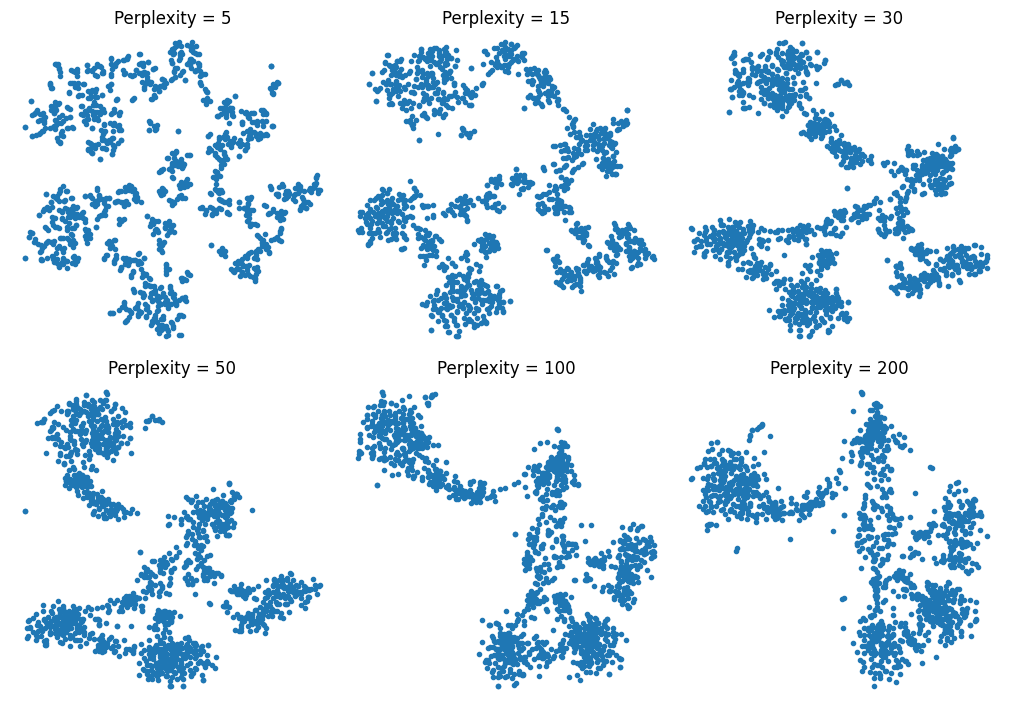

In [34]:
data_final = log_transform(cpm)
data_final = data_final[:, gene_var > np.sort(gene_var)[-501]]

perplexities = [5, 15, 30, 50, 100, 200]
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes_flat = np.ravel(axes)
measures = np.zeros((len(perplexities), 4))

for idx, perplexity in enumerate(perplexities):
    j = 0
    ax = axes_flat[idx]

    pca_result = sklearn.decomposition.PCA(n_components=50).fit_transform(
        data_final
    )
    tsne = sklearn.manifold.TSNE(
        n_components=2, perplexity=perplexity, random_state=7
    )
    tsne_results = tsne.fit_transform(pca_result)

    ax.scatter(tsne_results[:, 0], tsne_results[:, 1])
    ax.set_title(
        f"Perplexity = {perplexity}",
        fontsize=12,
    )
    ax.axis("off")

The paramater perplexity in t-SNE influences the balance between local and global aspects of the data, when creating the low-dimensional embedding. A low perplexity value focuses on capturing local structures, while a high perplexity focuses on global information. In this plot we plot the t-SNE embedding for different perplexity values. As the 2D-embedding will only be used to visualize our next analysis steps, we pick perplexity value 30 which differentiates the best between the clusters while having a high inner-cluster density. 

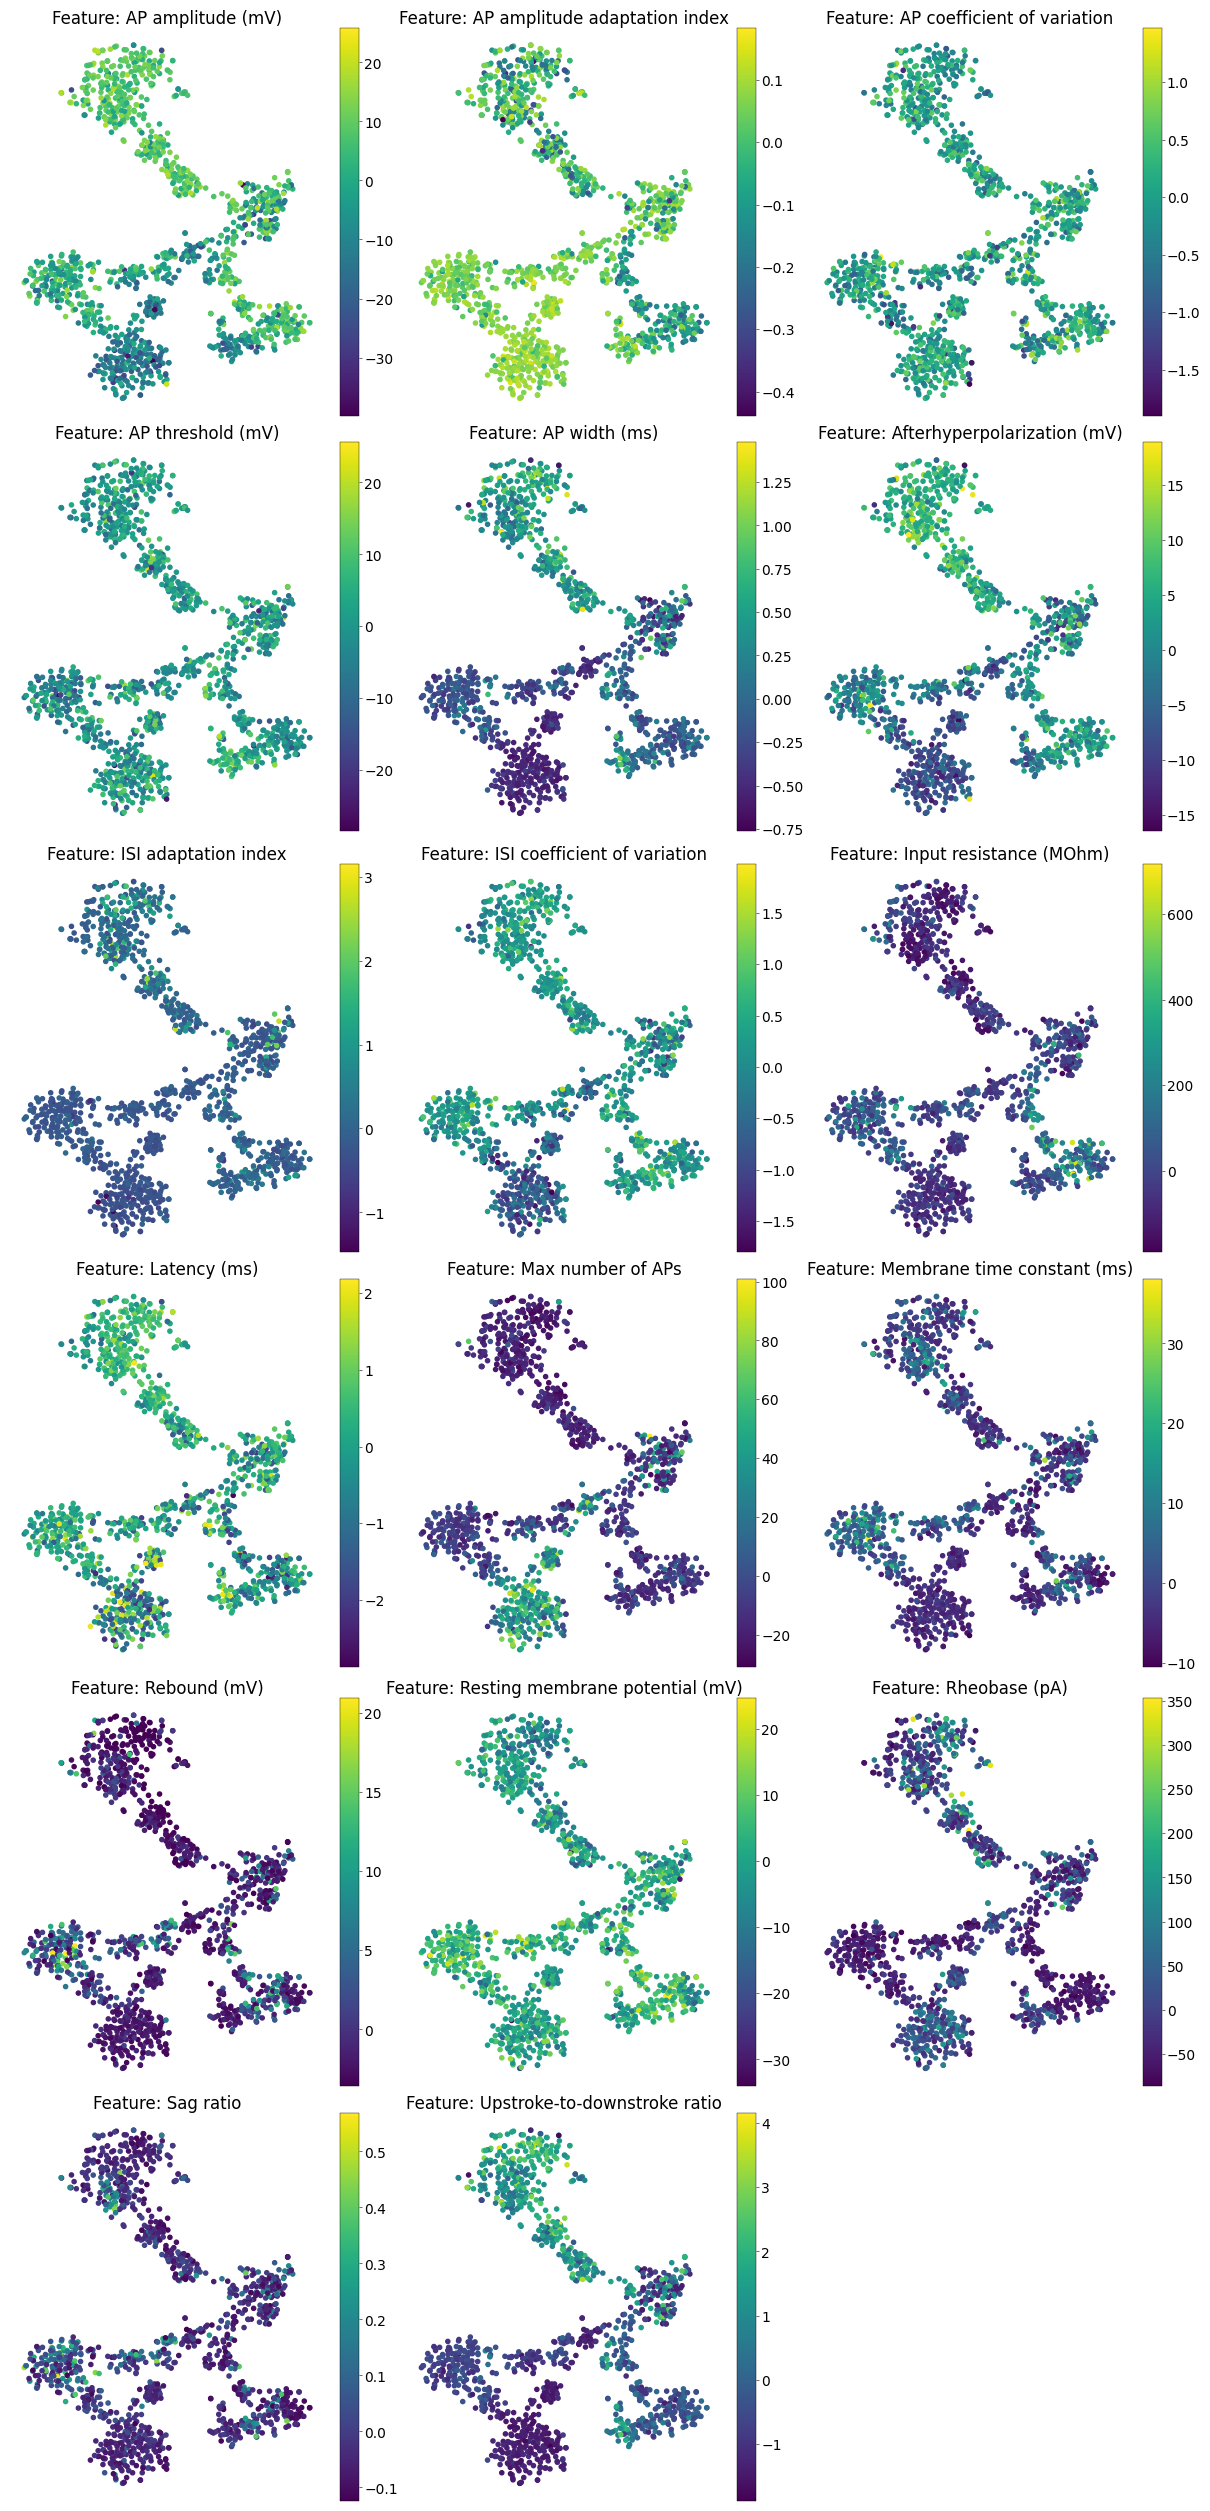

In [35]:
from matplotlib.colors import Normalize

fig, axes = plt.subplots(6, 3, figsize=(12, 25))
axes_flat = np.ravel(axes)
pca_result = sklearn.decomposition.PCA(n_components=50).fit_transform(
    data_final
)
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=30, random_state=7)
tsne_results = tsne.fit_transform(pca_result)

for idx in range(0, len(X[0, :])):
    ax = axes_flat[idx]
    x = X[:, idx]

    scatter = ax.scatter(
        tsne_results[keepcells, 0], tsne_results[keepcells, 1], c=x
    )
    ax.set_title(
        f"Feature: {ephysNames[idx]}",
        fontsize=12,
    )
    ax.axis("off")

    cbar = plt.colorbar(scatter, ax=ax)

axes_flat[17].axis("off")
plt.show()

In this plot, the t-SNE embedding is colored based on electrophysiological features. Some features correspond to distinct clusters for example the Max Number of APs or the Upstroke-to-Downstroke ratio show one cluster with values that differ from all the others. This might indicate that there are different cell types, which have different features. 

## 4) Clustering ##

Based on the results before, we continue the analysis with CPM normalization and log transformation. In total we try three different clustering approaches: 
1. Leiden clustering 
2. Gaussian mixture model 
3. Negative binomial mixture model

Each method has different hyperparamters that in the end define how many clusters will be identified. To find the hyperparameters we consider different metricies: 

* silhouette-score  
* adjusted rand index 
* davies-bouldin score 
* baysian information criterion

### True Cluster inspection

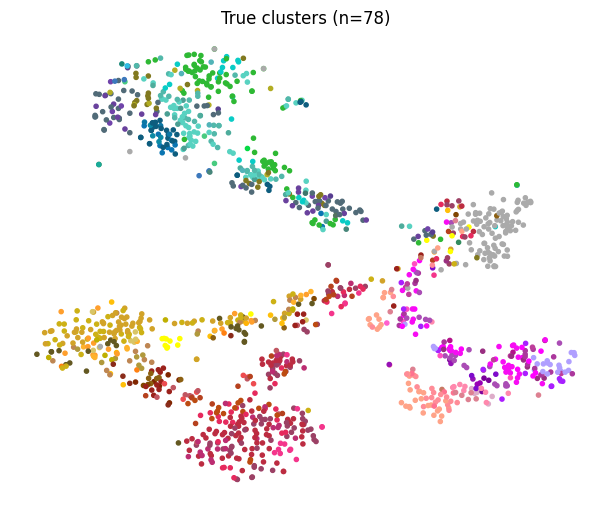

silhouette score: 	-0.10
davies_bouldin score: 	4.01


In [36]:
# transform the cluster colors into an array of cluster numbers
n_cells = data_final.shape[0]
true_labels = np.zeros(n_cells)
for i in range(n_cells):
    true_labels[i] = np.argwhere(
        np.unique(cluster_colors) == cluster_colors[i]
    )[0, 0]

# caclulate metricies that dont need a reference/likelihood
sil_score = sklearn.metrics.silhouette_score(data_final, true_labels)
db_score = sklearn.metrics.davies_bouldin_score(data_final, true_labels)

# plot true clusters
pca_result = sklearn.decomposition.PCA(n_components=50).fit_transform(
    data_final
)
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=30, random_state=7)
tsne_results = tsne.fit_transform(pca_result)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.set_title(f"True clusters (n={len(np.unique(cluster_colors))})")
ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_colors)
ax.axis("off")
plt.show()

print(f"silhouette score: \t{sil_score:.2f}")
print(f"davies_bouldin score: \t{db_score:.2f}")

The authors identify 78 differenct clusters. We will use this cluster assignment as true clusters in our following evaluation of the algorithms. \
One can see that the clusters are distinct in the tsne plot, but still show partly substantial overlap. E.g. the bluish and red clusters in the top and the redih colors in the bottom. \
We calculated the silhouette score and the davies-bouldin score for the original data and got quite bad values, which indicate that those metricies may not be very suitable for our dataset to evaluate the clustering performance. These metricies rely on the distances between the samples and the clusters and therefore might not be able to capture non spherical clusters and clusters with different widths. Also, the overlapping clusters might be an issue, even though we don't know if the clusters also overlap in the high dimensional space, but the tsne plot points in that direction. \
Because of this, we conclude that these metrices are not suitable for our data set and therefore we don't use them to assess clustering quality in the furhter analysis.

### GMM

We want to find the amount of components (=classes) in the GMM that gives the best clustering result. Therefore we fit the model multiple times using diffferent random seeds and amount of components and then inspect the adjust rand index and the bic values. 

In [37]:
## run GMM for various different components for N = 5 different random states
from sklearn.mixture import GaussianMixture
import tqdm

N_RUNS = 10
L_n_components = [
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    20,
    30,
    50,
    70,
    100,
]


gmm_sil_scores = np.zeros((N_RUNS, len(L_n_components)))
gmm_db_scores = np.zeros((N_RUNS, len(L_n_components)))
gmm_ar_scores = np.zeros((N_RUNS, len(L_n_components)))
gmm_bic_scores = np.zeros((N_RUNS, len(L_n_components)))
for i in tqdm.tqdm(range(N_RUNS)):
    for j, n_components in enumerate(L_n_components):
        # fit GMM
        gmm = GaussianMixture(n_components=n_components, random_state=i).fit(
            data_final
        )

        # calculate different metrices
        gmm_sil_scores[i, j] = sklearn.metrics.silhouette_score(
            data_final, gmm.predict(data_final)
        )
        gmm_db_scores[i, j] = sklearn.metrics.davies_bouldin_score(
            data_final, gmm.predict(data_final)
        )
        gmm_ar_scores[i, j] = sklearn.metrics.adjusted_rand_score(
            true_labels, gmm.predict(data_final)
        )
        gmm_bic_scores[i, j] = gmm.bic(data_final)

100%|██████████| 10/10 [10:08<00:00, 60.88s/it]


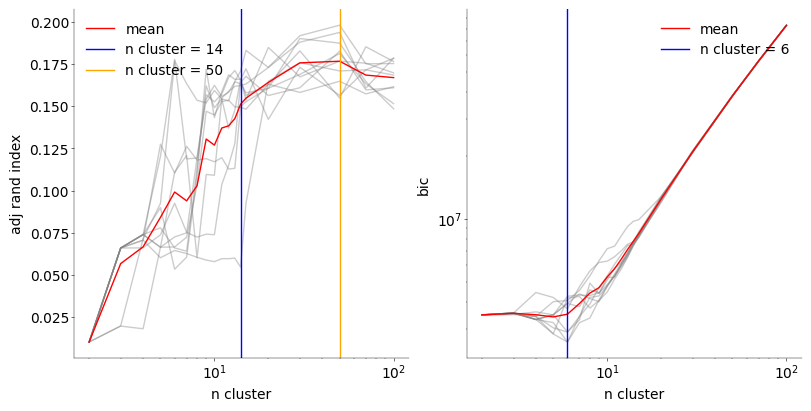

In [38]:
# plot the different metrices

metrices = [gmm_ar_scores, gmm_bic_scores]
metrices_names = ["adj rand index", "bic"]

fig, axs = plt.subplots(1, len(metrices), figsize=(8, 4), sharex=True)
for i, ax in enumerate(axs):
    for j in range(N_RUNS):
        ax.plot(L_n_components, metrices[i][j, :], color="gray", alpha=0.4)
    ax.plot(
        L_n_components, np.mean(metrices[i], axis=0), color="red", label="mean"
    )
    ax.set_ylabel(metrices_names[i])
    ax.set_xscale("log")
    ax.set_xlabel("n cluster")

# add specific visuals
axs[0].axvline(14, color="blue", label="n cluster = 14")
axs[0].axvline(50, color="orange", label="n cluster = 50")
axs[0].legend(loc="upper left")
axs[1].axvline(6, color="blue", label="n cluster = 6")
axs[1].legend(loc="upper right")
axs[1].set_yscale("log")

For the adjusted rand index we can see that the value rises roughly until 14 clusters and then starts to plateau. This indicates that more components than 14 dont increase the clustering performance. The best value is obtained at 50 clusters, before the ari starts to decrease again. \
The bic has a minimum at 6 clusters, meaning that 6 clusters are a good trade off between model complexity and likelihood. \
To evaluate that further we visually inspect the clusterings for the best runs for 6 (min bic), 14 and 50 clusters (max adj run index).

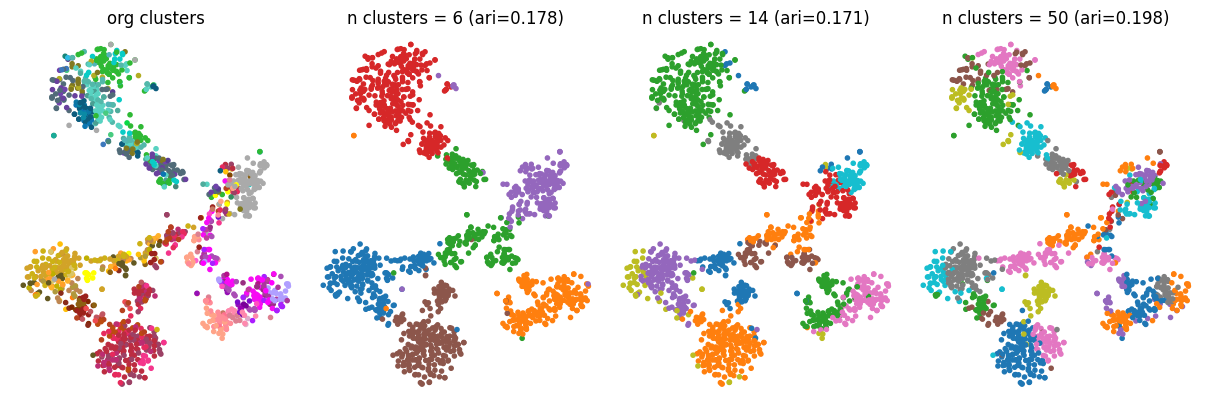

In [39]:
# define cluster colors for all clustering plots
COLORS = np.array(sns.color_palette(n_colors=100).as_hex())

best_gmm_clusters = []
best_gmm_ari = 0

min_bic_6 = np.argmin(
    gmm_bic_scores[:, np.argwhere(np.array(L_n_components) == 6)[0, 0]]
)
max_ari_14 = np.argmax(
    gmm_ar_scores[:, np.argwhere(np.array(L_n_components) == 14)[0, 0]]
)
max_ari_50 = np.argmax(
    gmm_ar_scores[:, np.argwhere(np.array(L_n_components) == 50)[0, 0]]
)
n_components = [6, 14, 50]
random_seeds = [min_bic_6, max_ari_14, max_ari_50]

fig, axs = plt.subplots(1, 4, figsize=(12, 4))

axs[0].scatter(
    tsne_results[:, 0],
    tsne_results[:, 1],
    c=cluster_colors,
)
axs[0].set_title("org clusters")
axs[0].axis("off")
for i, ax in enumerate(axs[1:]):
    clusters = GaussianMixture(
        n_components=n_components[i], random_state=random_seeds[i]
    ).fit_predict(data_final)

    ari = sklearn.metrics.adjusted_rand_score(true_labels, clusters)
    ax.scatter(
        tsne_results[:, 0],
        tsne_results[:, 1],
        c=COLORS[clusters],
    )
    ax.axis("off")
    ax.set_title(f"n clusters = {n_components[i]} (ari={ari:.3f})")

    # store best GMM clusters
    if i == 2:
        best_gmm_clusters = clusters
        best_gmm_ari = ari

The clustering for 6 clusters does capture a broad structure, so that close samples in the tsne plot are mostly assigned to the same cluster. However, there are many clusters that are merged together, as it is expected for such a low number of clusters in comparision to the true clusters. For 14 and 50 clusters, there is finer structure within the clusters. However, this does not really correspond to the true clusters. E.g. the yellow and orange cluster on the lower left in the true clusters is split in half for the plots with 14 and 50 clusters. A simple observation can be mode for the redish cluster in the bottom in the orginal plot and 50 cliusters. For 6 and 14 clusters these region is just identified as one cluster. \
While the clustering in general looks okay, it can be said that none of the shown clusterings are convincingly representing the true clusters.

### Leiden 
For Leiden clustering, one can specify the resolution, upon which the amount of clusters depend. To find an appropriate resolution, we use the adjusted rand index as metric and run the clustering approach mutliple times with different random seeds 

In [40]:
### Leiden
import igraph as ig
from sklearn.neighbors import kneighbors_graph
import leidenalg as la
import sklearn.metrics
import tqdm

A = kneighbors_graph(data_final, 15)
sources, targets = A.nonzero()
A = ig.Graph(zip(sources, targets))

resolutions = np.arange(0.1, 20, 0.5)

leiden_ar_scores = np.zeros((N_RUNS, len(resolutions)))
for i in tqdm.tqdm(range(N_RUNS)):
    for j, resolution in enumerate(resolutions):
        partition = la.find_partition(
            A,
            la.RBConfigurationVertexPartition,
            resolution_parameter=resolution,
            seed=i,
        )
        leiden_ar_scores[i, j] = sklearn.metrics.adjusted_rand_score(
            true_labels, partition.membership
        )

100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


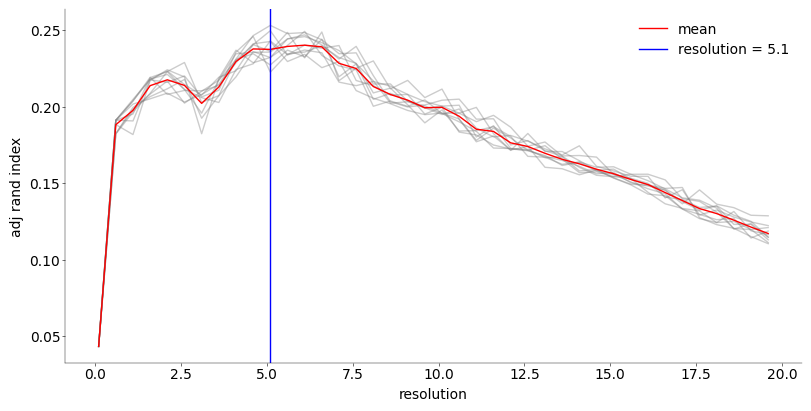

In [41]:
# plot the different metrices

metrices_names = ["adj rand index"]

plt.figure(figsize=(8, 4))
for j in range(N_RUNS):
    plt.plot(resolutions, leiden_ar_scores[j, :], color="gray", alpha=0.4)
plt.plot(
    resolutions, np.mean(leiden_ar_scores, axis=0), color="red", label="mean"
)
plt.ylabel("adj rand index")
plt.xlabel("resolution")

# add specific visuals
plt.axvline(5.1, color="blue", label="resolution = 5.1")
plt.legend(loc="upper right")
plt.show()

One can see that there is relatively little variance in the adjusted rand index value for different random seeds. The largers mean ari value is obtained at a resolution of 5.1, with ~0.24, which is higher then for the GMM models. We now want to inspect the clustering with the highest ari visually and plot one example trial to illustrate the influence of the resolution paramter.

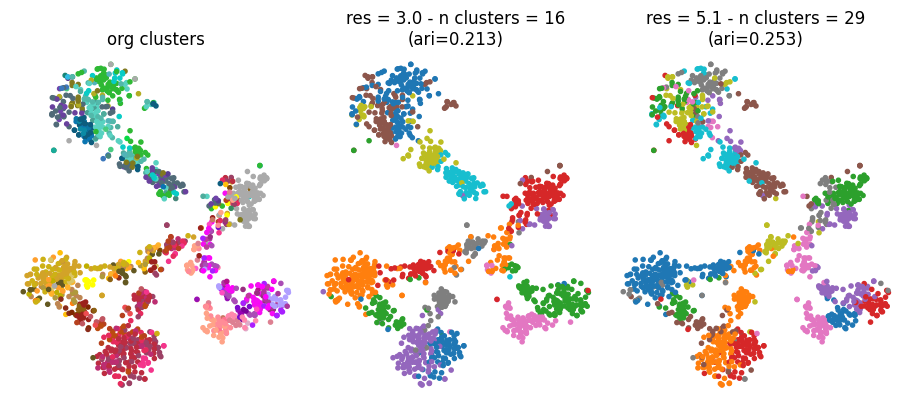

In [42]:
# plot true clusters
fig, axs = plt.subplots(1, 3, figsize=(9, 4))
axs[0].scatter(
    tsne_results[:, 0],
    tsne_results[:, 1],
    c=cluster_colors,
)
axs[0].set_title("org clusters")
axs[0].axis("off")

# plot example run
partition = la.find_partition(
    A,
    la.RBConfigurationVertexPartition,
    resolution_parameter=3,
    seed=0,
)
ari = sklearn.metrics.adjusted_rand_score(true_labels, partition.membership)
best_leiden_clusters = partition.membership
best_leiden_ari = ari
axs[1].scatter(
    tsne_results[:, 0],
    tsne_results[:, 1],
    c=COLORS[partition.membership],
)
axs[1].set_title(
    f"res = 3.0 - n clusters = {len(np.unique(partition.membership))}\n(ari={ari:.3f})"
)
axs[1].axis("off")

# plot best run
seed = np.argmax(
    leiden_ar_scores[:, np.argwhere(np.array(resolutions) == 5.1)[0, 0]]
)
partition = la.find_partition(
    A,
    la.RBConfigurationVertexPartition,
    resolution_parameter=5.1,
    seed=seed,
)
ari = sklearn.metrics.adjusted_rand_score(true_labels, partition.membership)
best_leiden_clusters = partition.membership
best_leiden_ari = ari

axs[2].scatter(
    tsne_results[:, 0],
    tsne_results[:, 1],
    c=COLORS[partition.membership],
)
axs[2].set_title(
    f"res = 5.1 - n clusters = {len(np.unique(partition.membership))}\n(ari={ari:.3f})"
)
axs[2].axis("off")

plt.show()

One can see that the that the clusters are distinct but also scattered across the plot. E.g. the orange and green cluster in for a resolution of 3.0 and 5.1. Looking at the true labels, it stands out that this is also the case of the true clusters. E.g. the purple, dark red and light green. For the best clustering (ari = 0.254 and 29 cluster), there are clusters that seem to represent the true clustering quite well. E.g. compare the the ark red (org) and the orange clusters, that stretch from the bottom to the center of the tsne plots. However, there seem to be clusters e.g. the green one (in 29 cluster plot) that are quite separated, which cant be seen in the true cluster plot.  

### Negative Binomial mixture model
We implemented a version of a negative binomial mixture model following the papers instructions. We avoided the optimization of the number of cluster but instead gave the number of cluster as hyperparameter. Based on the paper we used a hard EM approach.  Since the model runs quite long, we evaluate the adjusted rand index for a set of 4-20 clusters for 3 times (took ~15min).

In [43]:
# negative binomial model implementation
from sklearn.cluster import KMeans


# calculate posteriors using bayes
def e_step(data, ps, pis):
    n_cells = data.shape[0]
    n_genes = data.shape[1]
    n_cluster = len(pis)

    # log likelihood
    gamma = np.zeros((n_cells, n_cluster))
    for i in range(n_cells):
        for k in range(n_cluster):
            gamma[i, k] = np.log(pis[k]) + np.sum(
                [
                    data[i, g] * np.log(ps[k, g]) + 2 * np.log(1 - ps[k, g])
                    for g in range(n_genes)
                ]
            )

    # "hard EM"
    clusters = np.array([np.argmax(x) for x in gamma])

    return clusters


def m_step(data, clusters, n_cluster):
    n_cells = data.shape[0]
    n_genes = data.shape[1]

    ps = np.zeros((n_cluster, n_genes))

    # priors
    pis = [np.sum(clusters == c) / n_cells for c in range(n_cluster)]

    # calculcate max likelihood estimates for p
    for i in range(n_cluster):
        for g in range(n_genes):
            mu = (np.sum(data[clusters == i, g]) + 10**-4) / (
                1 + np.sum(clusters == i)
            )
            ps[i, g] = mu / (2 + mu)

    return [pis, ps]


def neg_binom_model(data, n_cluster, seed=1, r=2, max_iter=100):

    n_cells = data.shape[0]
    n_genes = data.shape[1]

    # init
    ps = np.random.rand(n_cluster, n_genes)
    pis = np.ones(n_cluster) / n_cluster

    kmeans = KMeans(
        n_clusters=n_cluster, random_state=seed, n_init="auto"
    ).fit(data)
    clusters = kmeans.labels_
    clusters_old = clusters

    # fit model
    for i in range(max_iter):

        # m step
        [pis, ps] = m_step(data, clusters, n_cluster)

        # e step
        clusters = e_step(data, ps, pis)

        if i != 0:
            conv = np.sum(clusters_old == clusters) / len(clusters)
            if conv > 0.99:
                return clusters

        clusters_old = clusters

    return clusters

In [44]:
N_RUNS = 3
NB_n_clusters = [4, 6, 8, 10, 12, 14, 20]

nb_ar_scores = np.zeros((N_RUNS, len(NB_n_clusters)))
for i in tqdm.tqdm(range(N_RUNS)):
    for j, n_cluster in enumerate(NB_n_clusters):

        clusters = neg_binom_model(data_final, n_cluster, seed=i + 3)

        nb_ar_scores[i, j] = sklearn.metrics.adjusted_rand_score(
            true_labels, clusters
        )

100%|██████████| 3/3 [20:52<00:00, 417.64s/it]


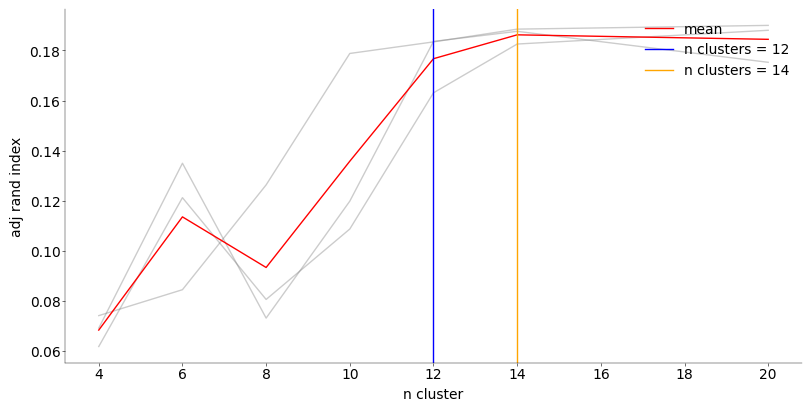

In [45]:
# plot the different metrices

metrices_names = ["adj rand index"]

plt.figure(figsize=(8, 4))
for j in range(N_RUNS):
    plt.plot(NB_n_clusters, nb_ar_scores[j, :], color="gray", alpha=0.4)
plt.plot(
    NB_n_clusters,
    np.mean(nb_ar_scores, axis=0),
    color="red",
    label="mean",
)
plt.ylabel("adj rand index")
plt.xlabel("n cluster")

# # add specific visuals
plt.axvline(12, color="blue", label="n clusters = 12")
plt.axvline(14, color="orange", label="n clusters = 14")
plt.legend(loc="upper right")
plt.show()

It can be seen that the ari increases with a larger cluster amount and seems to plateau after 14 clusters. We want to inspect visally the best clustering for 12 clusters, which looks like the point where the ari does not increases a lot with increasing cluster size and for 14 clusters, which seem to have on average the best ari.

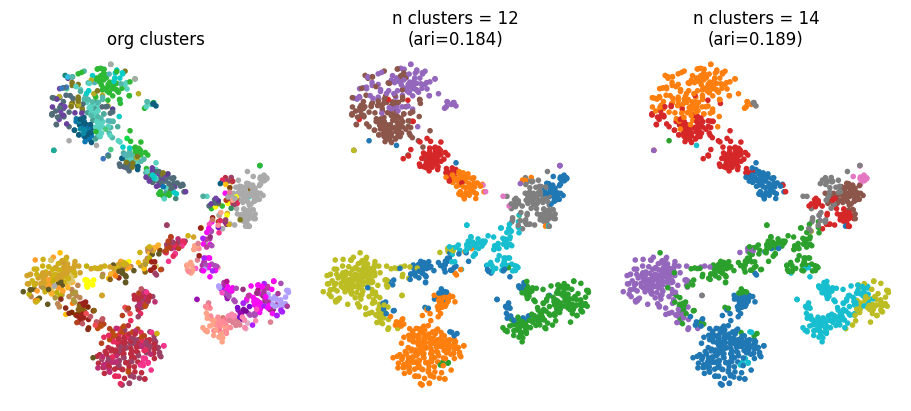

In [46]:
best_nb_clusters = []
best_nb_ari = 0

clusters_inspect = [12, 14]

fig, axs = plt.subplots(1, 3, figsize=(9, 4))
axs[0].scatter(
    tsne_results[:, 0],
    tsne_results[:, 1],
    c=cluster_colors,
)
axs[0].set_title("org clusters")
axs[0].axis("off")

for i, cluster_n in enumerate(clusters_inspect):
    seed = np.argmax(
        nb_ar_scores[
            :, np.argwhere(np.array(NB_n_clusters) == cluster_n)[0, 0]
        ]
    )

    clusters = neg_binom_model(data_final, cluster_n, seed=seed + 3)

    ari = sklearn.metrics.adjusted_rand_score(true_labels, clusters)

    axs[i + 1].scatter(
        tsne_results[:, 0],
        tsne_results[:, 1],
        c=COLORS[clusters],
    )
    axs[i + 1].axis("off")
    axs[i + 1].set_title(f"n clusters = {cluster_n}\n(ari={ari:.3f})")

    if i == 1:
        best_nb_clusters = clusters
        best_nb_ari = ari

plt.show()

The clustering for 12 and 14 clusters does not seem really good. Again close points in our 2d visualization typically belong to the same cluster, but many clusters from the orignal cluster labels are merged together. Additionally, e.g. on the top right there is a cluster in the true clusters (gray) that is splitted for the case of the negative binomial clusterings

### Comparison

While trying different metrices, we found that the adjusted rand index was best suited for our data set and it is also applicable for all of our clustering methods. Since the methods performed very different depending on their hyperparameters, we tried to find the best hyperparameters for each method by considering multiple runs with different seeds and evaluating the adjusted rand index. From visual inpsection and from absolute values, leiden clustering seems to replicate the true clusterings best, with a resolution of 5.1, which results in 29 clusters. However the difference in absolute ari value is not very large. 

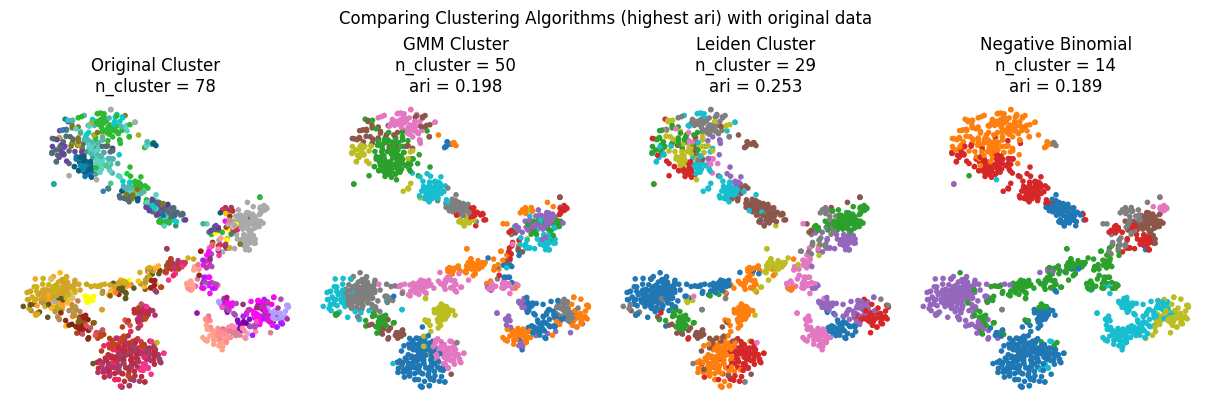

In [47]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
fig.suptitle(
    "Comparing Clustering Algorithms (highest ari) with original data"
)


axes[0].scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_colors)
axes[1].scatter(
    tsne_results[:, 0],
    tsne_results[:, 1],
    c=COLORS[best_gmm_clusters],
)
axes[2].scatter(
    tsne_results[:, 0],
    tsne_results[:, 1],
    c=COLORS[best_leiden_clusters],
)
axes[3].scatter(
    tsne_results[:, 0],
    tsne_results[:, 1],
    c=COLORS[best_nb_clusters],
)

axes[0].set_title(
    f"Original Cluster\nn_cluster = {len(np.unique(cluster_colors))}"
)
axes[1].set_title(
    f"GMM Cluster\nn_cluster = {len(np.unique(best_gmm_clusters))}\nari = {best_gmm_ari:.3f}"
)
axes[2].set_title(
    f"Leiden Cluster\nn_cluster = {len(np.unique(best_leiden_clusters))}\nari = {best_leiden_ari:.3f}"
)
axes[3].set_title(
    f"Negative Binomial\nn_cluster = {len(np.unique(best_nb_clusters))}\nari = {best_nb_ari:.3f}"
)

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")
axes[3].axis("off")
plt.show()

## 5) Correlation

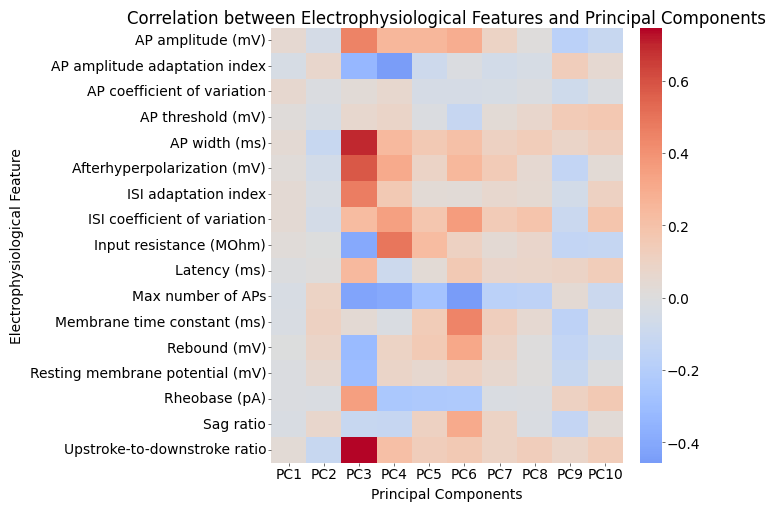

The three PCs with highest correlation in electrophysiological features: [1]


In [48]:
from scipy.stats import pearsonr

counts = data_final[keepcells]

n_components = 10
pca = PCA(n_components=n_components)
pcs = pca.fit_transform(counts)
loadings = np.abs(pca.components_)

combined_data = np.hstack((pcs, X))

correlations = np.zeros((X.shape[1], pcs.shape[1]))
p_values = np.zeros((X.shape[1], pcs.shape[1]))

for i in range(X.shape[1]):
    for j in range(pcs.shape[1]):
        corr, p_value = pearsonr(X[:, i], pcs[:, j])
        correlations[i, j] = corr
        p_values[i, j] = p_value
plt.figure(figsize=(7, 5))
sns.heatmap(
    correlations,
    annot=False,
    cmap="coolwarm",
    center=0,
    xticklabels=[f"PC{j+1}" for j in range(pcs.shape[1])],
    yticklabels=[ephysNames[idx] for idx in range(len(ephysNames))],
)
plt.title(
    "Correlation between Electrophysiological Features and Principal Components"
)
plt.xlabel("Principal Components")
plt.ylabel("Electrophysiological Feature")
plt.show()
most_impact = np.argsort(np.sum(correlations**2))
print(
    f"The three PCs with highest correlation in electrophysiological features: {most_impact[0:3]+ 1}"
)

To find correlations between the electrophysiological features and the genes/the principle components of the exon count data, we analyzed the correlations between each of the electrophysiological features with the 10 principle components with the highest explained variance. We took the Pearson correlation coefficent as a measure of the correlation. In the heatmap, we can observe the biggest correlations with the electrophysiological features in the components 3, 4 and 6. 

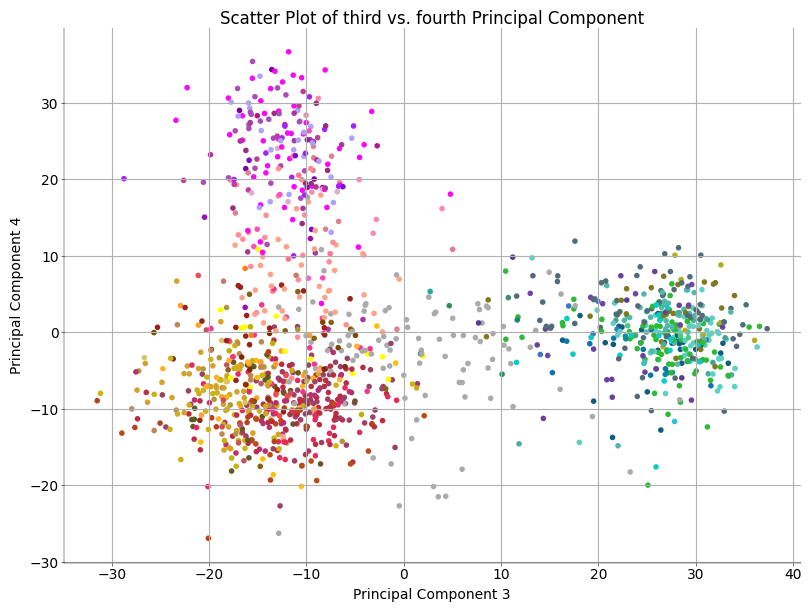

In [49]:
pc2 = pcs[:, 2]
pc3 = pcs[:, 3]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    pc2, pc3, c=cluster_colors[keepcells]
)  # Adjust alpha and s for aesthetics
plt.title("Scatter Plot of third vs. fourth Principal Component")
plt.xlabel("Principal Component 3")
plt.ylabel("Principal Component 4")
plt.grid(True)
plt.show()

In the scatter plot we can observe that the two components 3 and 4 successfully cluster the data in 3 main clusters which also corresponds with the original cluster assignment (seen by the coloring).

C:\Users\nekur\AppData\Local\Temp\ipykernel_20604\2096070434.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


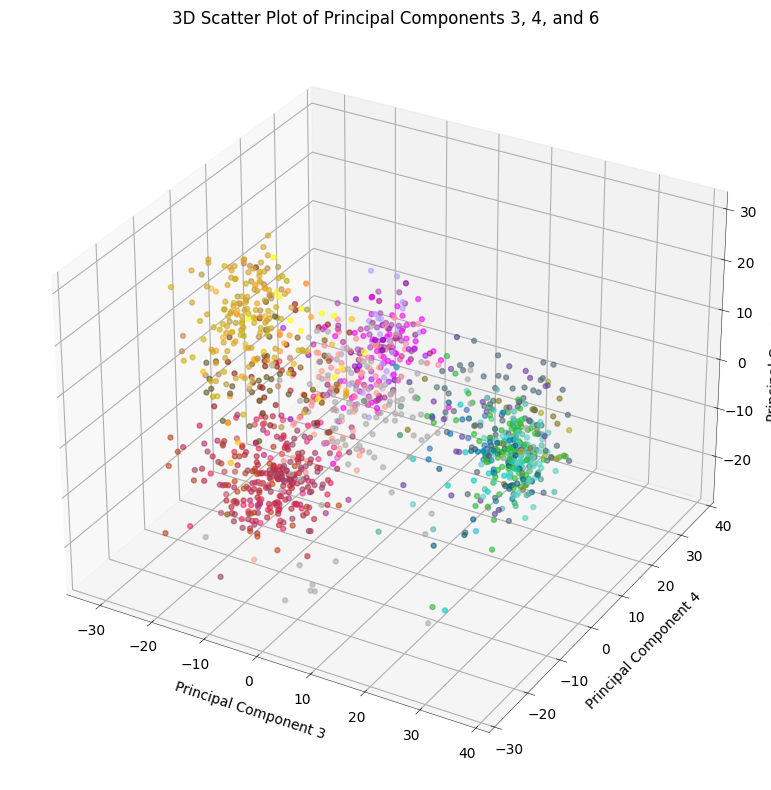

In [50]:
pc2 = pcs[:, 2]
pc3 = pcs[:, 3]
pc5 = pcs[:, 5]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(pc2, pc3, pc5, c=cluster_colors[keepcells], alpha=0.6, s=50)

# Add labels and title
ax.set_title("3D Scatter Plot of Principal Components 3, 4, and 6")
ax.set_xlabel("Principal Component 3")
ax.set_ylabel("Principal Component 4")
ax.set_zlabel("Principal Component 6")
plt.tight_layout()
plt.show()

By adding the sixth component, we can even identify four main clusters that also correspond with the gound truth cluster assignment.

In [51]:
genes_500 = genes[gene_var > np.sort(gene_var)[-501]]
gene_impact_idx = np.argsort(loadings, axis=1)[
    :, ::-1
]  # Sorted indices by absolute loadings in descending order
loadings_norm = loadings / np.sum(loadings, axis=1, keepdims=True)

# Print top genes for PC3
print("Top 5 genes with the most impact on Principal Component 3:")
for i in range(5):
    gene = genes_500[gene_impact_idx[2][i]]
    impact = 100 * loadings_norm[2][gene_impact_idx[2][i]]
    print(f"{i+1}. {gene} (Impact: {impact:.4f} %)")

# Print top genes for PC4
print("\nTop 5 genes with the most impact on Principal Component 4:")
for i in range(5):
    gene = genes_500[gene_impact_idx[3][i]]
    impact = 100 * loadings_norm[3][gene_impact_idx[3][i]]
    print(f"{i+1}. {gene} (Impact: {impact:.4f} %)")

# Print top genes for PC6
print("\nTop 5 genes with the most impact on Principal Component 6:")
for i in range(5):
    gene = genes_500[gene_impact_idx[5][i]]
    impact = 100 * loadings_norm[5][gene_impact_idx[5][i]]
    print(f"{i+1}. {gene} (Impact: {impact:.4f} %)")

Top 5 genes with the most impact on Principal Component 3:
1. Gad1 (Impact: 1.6320 %)
2. Slc6a1 (Impact: 1.4559 %)
3. Gad2 (Impact: 1.3327 %)
4. Slc17a7 (Impact: 1.2782 %)
5. Arpp21 (Impact: 1.2227 %)

Top 5 genes with the most impact on Principal Component 4:
1. Vip (Impact: 1.9362 %)
2. Adarb2 (Impact: 1.8457 %)
3. Fxyd6 (Impact: 1.4777 %)
4. Sez6 (Impact: 1.4121 %)
5. Kit (Impact: 1.2083 %)

Top 5 genes with the most impact on Principal Component 6:
1. Sst (Impact: 2.0101 %)
2. Erbb4 (Impact: 1.6293 %)
3. Synpr (Impact: 1.3989 %)
4. Grin3a (Impact: 1.3603 %)
5. Reln (Impact: 1.2727 %)


C:\Users\nekur\AppData\Local\Temp\ipykernel_20604\640517417.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


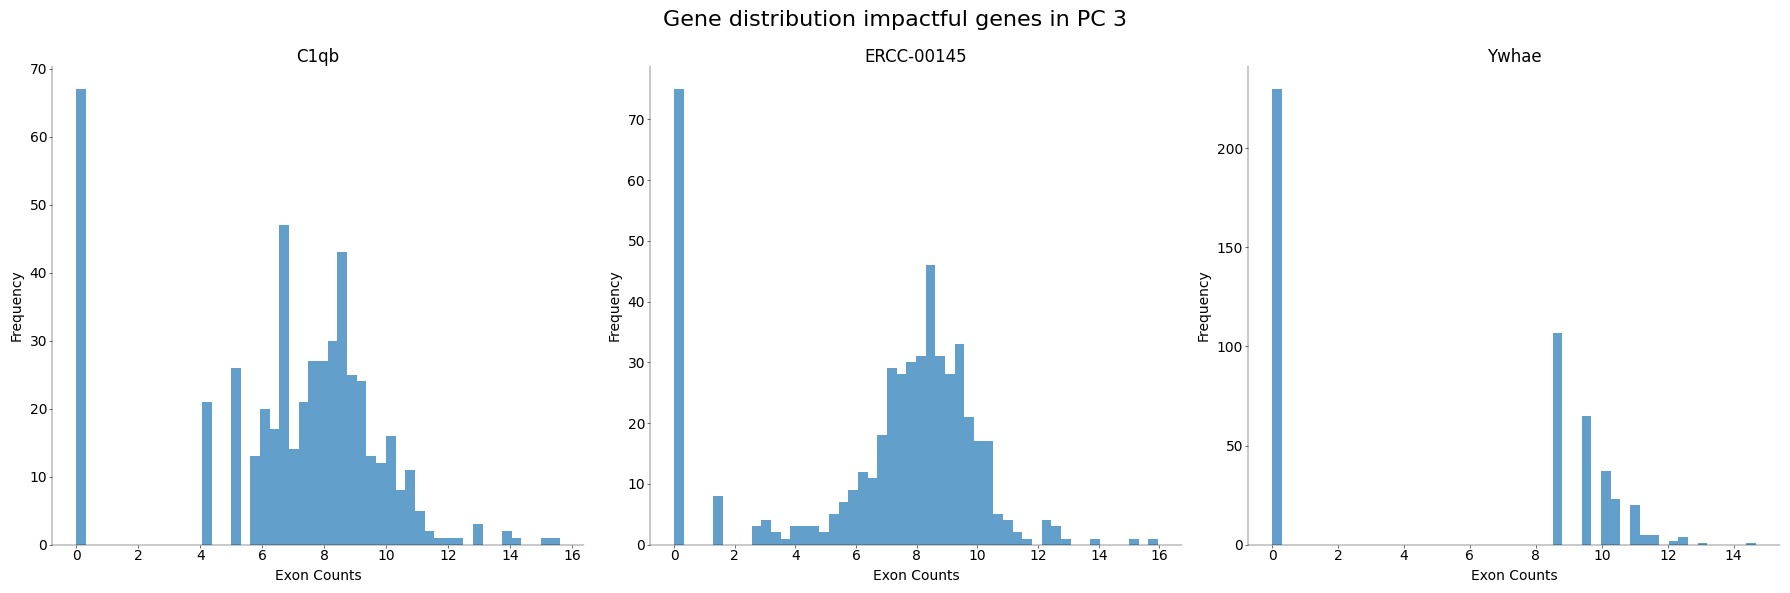

C:\Users\nekur\AppData\Local\Temp\ipykernel_20604\640517417.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


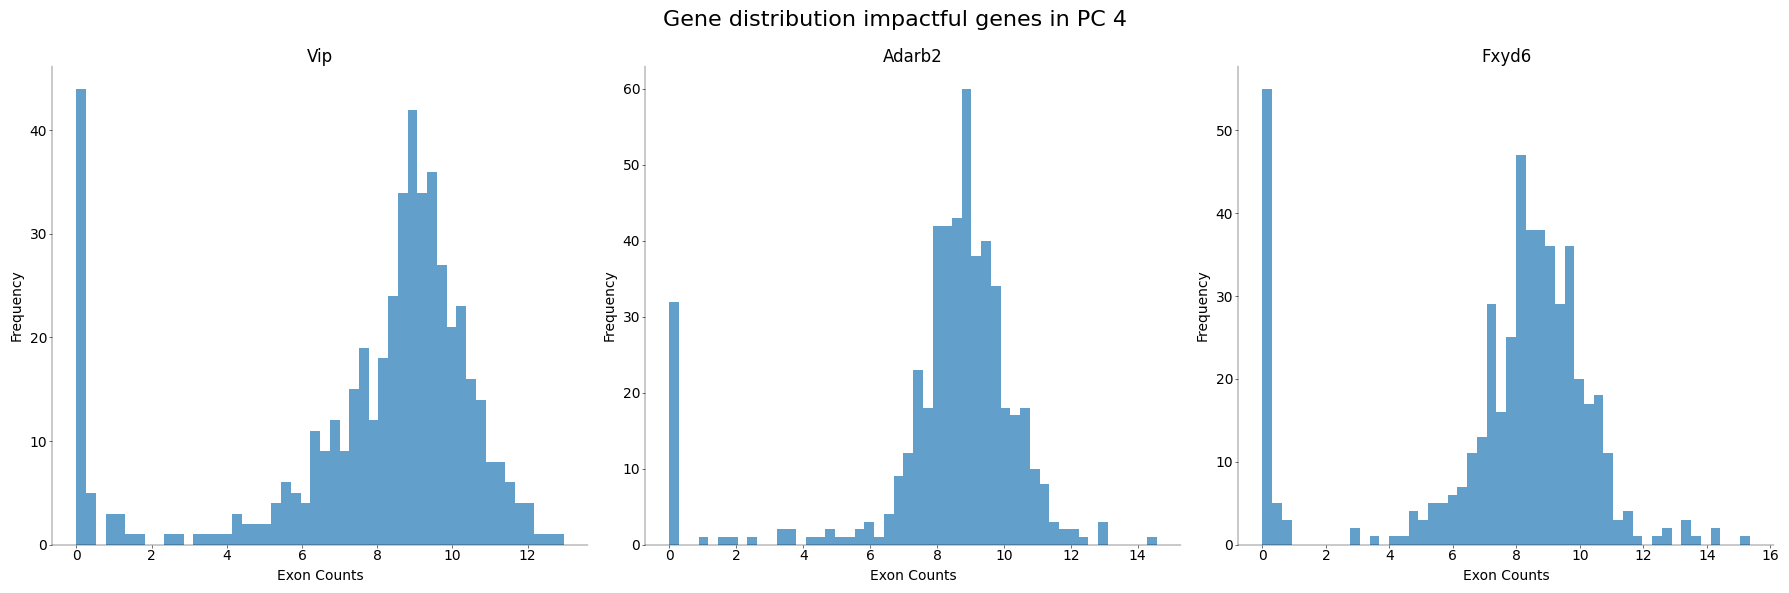

C:\Users\nekur\AppData\Local\Temp\ipykernel_20604\640517417.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


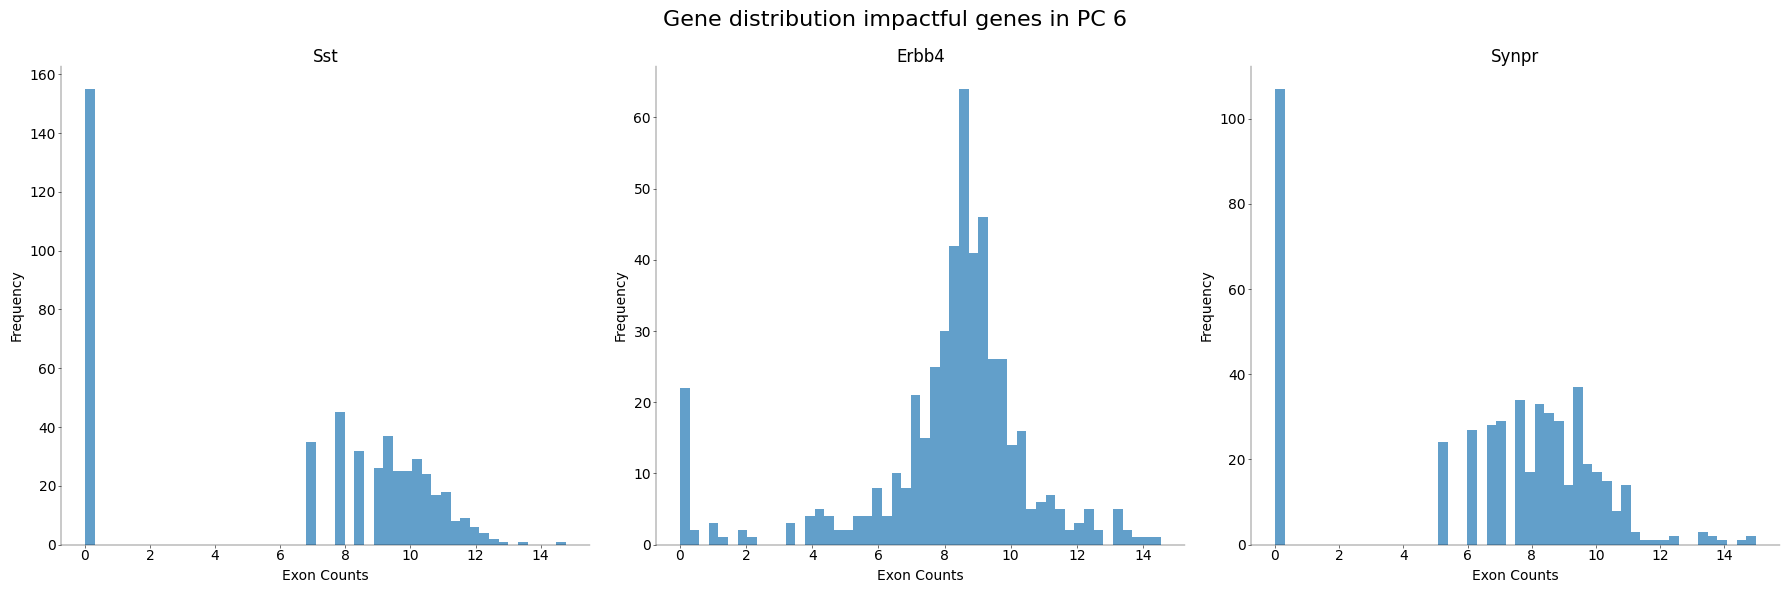

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

idx = np.argsort(loadings_norm[2, :])[:3]
for i in range(3):
    gene = genes_500[idx[i]]
    gene_count = data_final[idx[i]]

    ax[i].hist(gene_count, bins=50, alpha=0.7)
    ax[i].set_title(gene)
    ax[i].set_xlabel("Exon Counts")
    ax[i].set_ylabel("Frequency")

fig.suptitle("Gene distribution impactful genes in PC 3", fontsize=16)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

idx = np.argsort(-loadings_norm[3, :])[:3]
for i in range(3):
    gene = genes_500[gene_impact_idx[3][i]]
    gene_count = data_final[idx[i]]

    ax[i].hist(gene_count, bins=50, alpha=0.7)
    ax[i].set_title(gene)
    ax[i].set_xlabel("Exon Counts")
    ax[i].set_ylabel("Frequency")

fig.suptitle("Gene distribution impactful genes in PC 4", fontsize=16)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

idx = np.argsort(-loadings_norm[5, :])[:3]
for i in range(3):
    gene = genes_500[gene_impact_idx[5][i]]
    gene_count = data_final[idx[i]]

    ax[i].hist(gene_count, bins=50, alpha=0.7)
    ax[i].set_title(gene)
    ax[i].set_xlabel("Exon Counts")
    ax[i].set_ylabel("Frequency")

fig.suptitle("Gene distribution impactful genes in PC 6", fontsize=16)
plt.tight_layout()
plt.show()

We can assume that the genes that are listed as the most impactful for the individual principal components highly effect the position of the corresponding data point with respect to the components. By levaraging the high correlation of these components with the electrophysiological features, we can conclude that these genes have a high impact on the cell's electrophysiological behavior. And in fact when comparing the known functions of the individual genes that are observed above, one can see genes are all crucial in various aspects of neurotransmission, synaptic plasticity, and neuronal signaling, directly impacting the electrophysiological behavior of neurons. For example Gad1 is known to play a crucial role in GABA synthesis, which is directly relevant for inhibiting neural signalling (Dicken MS, Hughes AR, Hentges ST. Gad1 mRNA as a reliable indicator of altered GABA release from orexigenic neurons in the hypothalamus. Eur J Neurosci. 2015;42(9):2644-2653). Another example is the gene Vip that encodes for a neuropeptide and to which several electrophysiological properties are attributed (Badrinarayanan S, Manseau F, Williams S, Brandon MP. A characterization of the electrophysiological and morphological properties of vasoactive intestinal peptide (Vip) interneurons in the medial entorhinal cortex(Mec). Front Neural Circuits. 2021;15:653116.)